<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/BM_10layer_Thermal_history_22_06_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
import pandas as pd
import numpy as np
from math import *
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [2]:
!pip install GitPython

In [3]:
from git import Repo
!git clone https://github.com/MariiaKalinina/BM.git

Cloning into 'BM'...
remote: Enumerating objects: 1160, done.
remote: Counting objects: 100% (366/366), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 1160 (delta 332), reused 263 (delta 263), pack-reused 794 (from 2)
Receiving objects: 100% (1160/1160), 130.08 MiB | 14.47 MiB/s, done.
Resolving deltas: 100% (640/640), done.
Updating files: 100% (176/176), done.


### Step 0. Data preparation

In [4]:
# import pandas as pd

# Allen & Allne - Data (10 layers)
# df_constast = pd.read_csv('/content/BM/Initial data/Constants.csv', delimiter=';', header=0)
# df_well = pd.read_csv('/content/BM/Initial data/Well_parametrs.csv', delimiter=';', header=0)

# Test Data-1
df_constast = pd.read_csv('/content/BM/Initial data/Constants.csv', delimiter=';', header=0)
df_well = pd.read_csv('/content/BM/Initial data/Well_parametrs_test2.csv', delimiter=';', header=0)

# df_well = pd.read_csv('/content/Well_parametrs_v1.csv', delimiter=';', header=0) ### пример для 3х слойной модели
# df_well = pd.read_csv('/content/BM/Well_parametrs_A13.csv', delimiter=';', header=0) ### Geoterm test - Appendix 13

df_well[['Depth top, m', 'Depth bottom, m']] = df_well[['Depth top, m', 'Depth bottom, m']].apply(lambda x: x / 1000)

In [5]:
df_well

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, m","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Erosion,Erosion,NaN,0,0.00,0.30,NaN,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 10,Erosion,Shale (typical),0,0.30,0.50,200.0,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstone (typical),45,0.50,0.75,250.0,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shale (typical),55,0.75,1.50,750.0,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk (typical),80,1.50,2.80,1300.0,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstone (typical),100,2.80,3.70,900.0,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestone (ooid grainstone),125,3.70,3.90,200.0,NaN,20,70,On,0.0,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite (typical),145,3.90,4.30,400.0,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstone (typical),160,4.30,4.55,250.0,NaN,10,-20,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.55,5.30,750.0,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN


In [6]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shales,0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstones,0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk,0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestones,0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite,0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


### DataBase

In [7]:
import pandas as pd

file_path = '/content/BM/Initial data/Literature database from PM for all rock lithotypes.xlsx'

database = pd.ExcelFile(file_path)
print("Available sheets:", database.sheet_names)

for sheet_name in database.sheet_names:
    clean_name = sheet_name.replace(" ", "_").replace("-", "_")
    var_name = f"Database_{clean_name}"

    globals()[var_name] = pd.read_excel(
        file_path,
        sheet_name=sheet_name,
        header=0
    )
    print(f"Created variable: {var_name}")

Available sheets: ['Lithotypes', 'Kinetics all', 'Secondary cracking', 'Geochronology', 'SWIT_Map', 'SWIT_coordinates ', 'Global eustatic curve']
Created variable: Database_Lithotypes
Created variable: Database_Kinetics_all
Created variable: Database_Secondary_cracking
Created variable: Database_Geochronology
Created variable: Database_SWIT_Map
Created variable: Database_SWIT_coordinates_
Created variable: Database_Global_eustatic_curve


#### Lithology

In [8]:
from pandas.api.types import is_scalar

Database_Lithotypes.columns = Database_Lithotypes.iloc[0]
Database_Lithotypes = Database_Lithotypes.drop([0, 1]).reset_index(drop=True)

current_columns = Database_Lithotypes.columns
if is_scalar(current_columns[0]) and pd.isna(current_columns[0]):
    new_columns = list(current_columns)
    new_columns[0] = "Lithology type"
    Database_Lithotypes.columns = new_columns
Database_Lithotypes.head(7)


,Lithology type,Density,Initial porosity,Minimum porosity,Compaction model Key,Compressibility MAX,Compressibility MIN,Athy factor k (stress),Schneider Factor ka,Schneider factor kb,...,Ea,A,Clay Content,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options
0,Sandstone (typical),2720,41,1,Athy's law (depth),27.47,1.15,26.6,41.56,17.81,...,23.2,0.0,0,0,0,0,0,0,0,NaN
1,Sandstone (clay rich),2760,40,1,Athy's law (depth),26.54,1.11,26.61,40,18.12,...,23.2,0.0,0,0,0,0,0,0,0,NaN
2,Sandstone (clay poor),2700,42,1,Athy's law (depth),28.05,1.18,26.27,40.47,17.34,...,23.2,0.0,0,0,0,0,0,0,0,NaN
3,"Sandstone (quartzite, typical)",2640,42,1,Athy's law (depth),29.1,1.22,27.26,42.81,17.81,...,23.2,0.0,0,0,0,0,0,0,0,NaN
4,"Sandstone (quartzite, very quartz rich)",2640,42,1,Athy's law (depth),25.26,1.18,24.61,16.15,39.77,...,23.2,0.0,0,0,0,0,0,0,0,NaN
5,"Sandstone (subarkose, typical)",2680,41,1,Athy's law (depth),24.48,1.14,24.68,16.31,38.74,...,23.2,0.0,0,0,0,0,0,0,0,NaN
6,"Sandstone (subarkose, quartz rich)",2650,42,1,Athy's law (depth),26.34,1.19,25.33,39.84,16.41,...,23.2,0.0,0,0,0,0,0,0,0,NaN


In [9]:
df_well_with_properties = pd.merge(
    df_well,
    Database_Lithotypes,
    left_on='Lithology_type',
    right_on='Lithology type',
    how='left'
)
df_well_with_properties

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, m",...,Ea,A,Clay Content,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options
0,Test_well,Erosion,Erosion,NaN,0,0.00,0.30,NaN,NaN,300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 10,Erosion,Shale (typical),0,0.30,0.50,200.0,NaN,300,...,23.2,0.0,0,0,0,0,0,0,0,NaN
2,Test_well,Layer 9,Deposition,Sandstone (typical),45,0.50,0.75,250.0,NaN,325,...,23.2,0.0,0,0,0,0,0,0,0,NaN
3,Test_well,Layer 8,Deposition,Shale (typical),55,0.75,1.50,750.0,NaN,350,...,23.2,0.0,0,0,0,0,0,0,0,NaN
4,Test_well,Layer 7,Deposition,Chalk (typical),80,1.50,2.80,1300.0,NaN,300,...,23.2,0.0,0,0,0,0,0,0,0,NaN
5,Test_well,Layer 6,Deposition,Sandstone (typical),100,2.80,3.70,900.0,NaN,200,...,23.2,0.0,0,0,0,0,0,0,0,NaN
6,Test_well,Layer 5,Deposition,Limestone (ooid grainstone),125,3.70,3.90,200.0,NaN,20,...,23.2,0.0,0,0,0,0,0,0,0,NaN
7,Test_well,Layer 4,Deposition,Dolomite (typical),145,3.90,4.30,400.0,NaN,20,...,23.2,0.0,0,0,0,0,0,0,0,NaN
8,Test_well,Layer 3,Deposition,Sandstone (typical),160,4.30,4.55,250.0,NaN,10,...,23.2,0.0,0,0,0,0,0,0,0,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.55,5.30,750.0,NaN,20,...,23.2,0.0,0,0,0,0,0,0,0,NaN


In [10]:
df_well_with_properties.loc[
    df_well_with_properties["Event_name"] == 'Layer 9',
    ["Lithology_type", "Density", "Initial porosity", "Athy factor k (depth)", "Thermal conductivity at 20 oC",
    "Uranium", "Thorium", "Potassium"]
]

,Lithology_type,Density,Initial porosity,Athy factor k (depth),Thermal conductivity at 20 oC,Uranium,Thorium,Potassium
2,Sandstone (typical),2720,41,0.31,3.95,1.3,3.5,1.3


In [11]:
print("Current columns:")
for idx, col in enumerate(Database_Lithotypes.columns, 1):
    print(f"{idx}. {col}")

Current columns:
1. Lithology type
2. Density
3. Initial porosity
4. Minimum porosity
5. Compaction model Key
6. Compressibility MAX
7. Compressibility MIN
8. Athy factor k (stress)
9. Schneider Factor ka
10. Schneider factor kb
11. Schneider factor phi
12. Athy factor k (depth)
13. Multipoint curve
14. Curve flag
15. Depth curve
16. Effective stress curve
17. Compaction formula
18. Thermal conductivity model key
19. Thermal conductivity at 20 oC
20. Thermal conductivity at 100 oC
21. Thermal conductivity minimum temperature
22. Thermal conductivity max temperature
23. Thermal conductivity conductivity multi-point model
24. Anisotropy factor thermal conductivity
25. Depositional anisotropy
26. Depositional anisotropy
27. Thermal expansion coefficient 
28. Radiogenic model key
29. Uranium
30. Thorium
31. Potassium
32. Porosity
33. Gamma Ray
34. Time correction
35. HeatFlow Production value
36. Half Depth Value
37. Heat capacity model key
38. Heat capacity at 20 oC
39. Heat capacity at 1

In [12]:
sandstone_row = Database_Lithotypes[Database_Lithotypes['Lithology type'] == 'Sandstone (quartzite, very quartz rich)']
sandstone_row

,Lithology type,Density,Initial porosity,Minimum porosity,Compaction model Key,Compressibility MAX,Compressibility MIN,Athy factor k (stress),Schneider Factor ka,Schneider factor kb,...,Ea,A,Clay Content,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options
4,"Sandstone (quartzite, very quartz rich)",2640,42,1,Athy's law (depth),25.26,1.18,24.61,16.15,39.77,...,23.2,0.0,0,0,0,0,0,0,0,NaN


In [13]:
sandstone_row["Compressibility MIN"]

,Compressibility MIN
4,1.18


Check name of lithology to name in Database_Lithotypes

In [14]:
# Database_Lithotypes['Lithology type'].values
if 'Anhydrite' in Database_Lithotypes['Lithology type'].values:
    print("✅ found (case-sensitive match)")
else:
    print("❌ NOT found (case-sensitive match)")

✅ found (case-sensitive match)


In [15]:
df_well["Lithology_type"] = df_well["Lithology_type"].replace({
    "Sandstones": "Sandstone (typical)",
    "Shales": "Shale (typical)",
    "Limestones": "Limestone (ooid grainstone)",
    "Dolomite": "Dolomite (typical)",
    "Chalk": "Chalk (typical)",
    "Anhydrite": "Anhydrite",
    "Quartzite": "Sandstone (quartzite, very quartz rich)",
    # "Fundament": "Basement"

})

In [16]:
df_well

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, m","Sea level, m",Sublayers,N sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Erosion,Erosion,NaN,0,0.00,0.30,NaN,NaN,300,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Test_well,Layer 10,Erosion,Shale (typical),0,0.30,0.50,200.0,NaN,300,0,On,0.0,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstone (typical),45,0.50,0.75,250.0,NaN,325,40,On,0.0,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shale (typical),55,0.75,1.50,750.0,NaN,350,50,On,0.0,NaN,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk (typical),80,1.50,2.80,1300.0,NaN,300,100,On,0.0,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstone (typical),100,2.80,3.70,900.0,NaN,200,80,On,0.0,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestone (ooid grainstone),125,3.70,3.90,200.0,NaN,20,70,On,0.0,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite (typical),145,3.90,4.30,400.0,NaN,20,-40,On,0.0,NaN,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstone (typical),160,4.30,4.55,250.0,NaN,10,-20,On,0.0,Source Rock,Tegelaar(1994)_TI-S(Spain),10.0,100.0
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.55,5.30,750.0,NaN,20,0,On,0.0,NaN,NaN,NaN,NaN


In [17]:
df_well.to_csv('initial_well_data.csv', index=False)

In [18]:
df_constast["Lithology_type"] = df_constast["Lithology_type"].replace({
    "Sandstones": "Sandstone (typical)",
    "Shales": "Shale (typical)",
    "Limestones": "Limestone (ooid grainstone)",
    "Dolomite": "Dolomite (typical)",
    "Chalk": "Chalk (typical)",
    "Anhydrite": "Anhydrite",
    "Quartzite": "Sandstone (quartzite, very quartz rich)",
    # "Fundament": "Basement"
})

In [19]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shale (typical),0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstone (typical),0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk (typical),0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestone (ooid grainstone),0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite (typical),0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,"Sandstone (quartzite, very quartz rich)",0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


#### SWIT Map

In [20]:
Database_SWIT_Map.head(5)

,Unnamed: 0,Time,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 712,Unnamed: 713,Unnamed: 714,Unnamed: 715,Unnamed: 716,Unnamed: 717,Unnamed: 718,Unnamed: 719,Unnamed: 720,Unnamed: 721
0,Latitude,360.0000,359.5000,359.0000,358.5000,358.0000,357.5000,357.0000,356.5000,356.0000,...,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0
1,-90,9.2507,9.2344,9.2180,9.2015,9.1849,9.1679,9.1504,9.1323,9.1133,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,-89.5,9.2547,9.2381,9.2214,9.2047,9.1878,9.1705,9.1528,9.1344,9.1153,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,-89,9.2596,9.2426,9.2256,9.2087,9.1915,9.1740,9.1561,9.1375,9.1182,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,-88.5,9.2654,9.2480,9.2308,9.2135,9.1960,9.1784,9.1602,9.1415,9.1220,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [21]:
# Extract latitude
latitude = Database_SWIT_Map.iloc[1:, 0].astype(float).values
# Extract longitude
longitude = Database_SWIT_Map.iloc[0, 1:].astype(float).values
# Extract data values
data_values = Database_SWIT_Map.iloc[1:, 1:].astype(float).values

In [22]:
Database_SWIT_Map.head(5)

,Unnamed: 0,Time,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 712,Unnamed: 713,Unnamed: 714,Unnamed: 715,Unnamed: 716,Unnamed: 717,Unnamed: 718,Unnamed: 719,Unnamed: 720,Unnamed: 721
0,Latitude,360.0000,359.5000,359.0000,358.5000,358.0000,357.5000,357.0000,356.5000,356.0000,...,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0
1,-90,9.2507,9.2344,9.2180,9.2015,9.1849,9.1679,9.1504,9.1323,9.1133,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,-89.5,9.2547,9.2381,9.2214,9.2047,9.1878,9.1705,9.1528,9.1344,9.1153,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,-89,9.2596,9.2426,9.2256,9.2087,9.1915,9.1740,9.1561,9.1375,9.1182,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,-88.5,9.2654,9.2480,9.2308,9.2135,9.1960,9.1784,9.1602,9.1415,9.1220,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


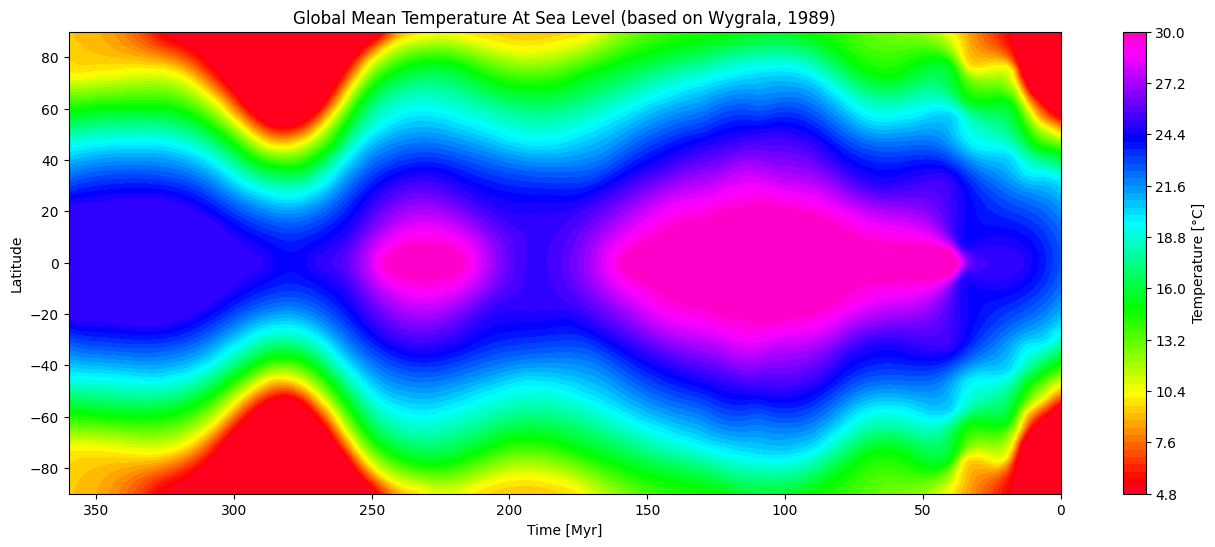

In [23]:
Lon, Lat = np.meshgrid(longitude, latitude)
plt.figure(figsize=(16, 6))
contour = plt.contourf(Lon, Lat, data_values, cmap='gist_rainbow', levels=80)

plt.colorbar(contour, label="Temperature [°C]")

plt.xlabel("Time [Myr]")
plt.ylabel("Latitude")
plt.title("Global Mean Temperature At Sea Level (based on Wygrala, 1989)")

plt.gca().invert_xaxis()
plt.show()

#### SWIT coordinates

In [24]:
import pandas as pd
import numpy as np


def process_paleolatitude_data(
    df: pd.DataFrame,
    reference_latitude: float
) -> pd.DataFrame:
    """
    Process paleolatitude data according to specified rules for northern and southern hemispheres.

    Args:
        df: Input DataFrame containing paleolatitude data
        reference_latitude: The reference latitude value (K) to match against current latitudes

    Returns:
        A processed DataFrame containing paleolatitude calculations with columns:
        - Continent
        - Hemisphere
        - Current_Latitude
        - Time
        - Paleolatitude
    """
    # Constants
    MAX_LATITUDE = 90
    MIN_LATITUDE = -90

    # Clean the input data
    cleaned_df = _clean_input_data(df)

    # Extract data components
    current_lats, hemispheres, continents, time_values, paleo_profiles = _extract_data_components(cleaned_df)

    # Process data according to hemisphere rules
    results = _process_hemisphere_data(
        current_lats=current_lats,
        hemispheres=hemispheres,
        continents=continents,
        time_values=time_values,
        paleo_profiles=paleo_profiles,
        reference_latitude=reference_latitude,
        max_lat=MAX_LATITUDE,
        min_lat=MIN_LATITUDE
    )

    # Format and return results
    return _format_results(results) if results else pd.DataFrame()


def _clean_input_data(df: pd.DataFrame) -> pd.DataFrame:
    """Remove rows containing explanatory text from the input DataFrame."""
    return df[~df.iloc[:, 0].str.contains('Adjusting|If Current Latitude', na=False)]


def _extract_data_components(df: pd.DataFrame) -> tuple:
    """
    Extract key data components from cleaned DataFrame.

    Returns:
        Tuple containing:
        - current_lats: Series of current latitude values
        - hemispheres: Series of hemisphere labels
        - continents: Series of continent names
        - time_values: Array of time values
        - paleo_profiles: DataFrame of paleolatitude profiles
    """
    current_lats = pd.to_numeric(df.iloc[1:, 1], errors='coerce').dropna()
    hemispheres = df.iloc[1:, 2]
    continents = df.iloc[1:, 3]
    time_values = pd.to_numeric(df.iloc[0, 4:], errors='coerce').dropna().values
    paleo_profiles = df.iloc[1:, 4:].apply(pd.to_numeric, errors='coerce')

    return current_lats, hemispheres, continents, time_values, paleo_profiles


def _process_hemisphere_data(
    current_lats: pd.Series,
    hemispheres: pd.Series,
    continents: pd.Series,
    time_values: np.ndarray,
    paleo_profiles: pd.DataFrame,
    reference_latitude: float,
    max_lat: float,
    min_lat: float
) -> list:
    """Process data according to hemisphere-specific rules."""
    results = []

    for idx, (current_lat, hemisphere, continent) in enumerate(zip(current_lats, hemispheres, continents)):
        profile = paleo_profiles.iloc[idx].dropna().values

        if len(profile) != len(time_values):
            continue

        if hemisphere == 'North' and np.isclose(current_lat, reference_latitude):
            adjusted = _calculate_adjusted_latitudes(
                profile,
                adjustment=reference_latitude,
                upper_bound=max_lat
            )
            results.append(_create_result_record(
                continent, hemisphere, current_lat, time_values, adjusted
            ))

        elif hemisphere == 'South' and np.isclose(current_lat, -reference_latitude):
            adjusted = _calculate_adjusted_latitudes(
                profile,
                adjustment=-reference_latitude,
                lower_bound=min_lat
            )
            results.append(_create_result_record(
                continent, hemisphere, current_lat, time_values, adjusted
            ))

    return results


def _calculate_adjusted_latitudes(
    profile: np.ndarray,
    adjustment: float,
    upper_bound: float = None,
    lower_bound: float = None
) -> np.ndarray:
    """
    Calculate adjusted latitudes with bounds checking.

    Args:
        profile: Array of paleolatitude values
        adjustment: Value to add to each latitude
        upper_bound: Maximum allowed latitude (optional)
        lower_bound: Minimum allowed latitude (optional)

    Returns:
        Array of adjusted latitudes respecting bounds
    """
    adjusted = profile + adjustment

    if upper_bound is not None:
        adjusted = np.where(adjusted > upper_bound, upper_bound, adjusted)
    if lower_bound is not None:
        adjusted = np.where(adjusted < lower_bound, lower_bound, adjusted)

    return adjusted


def _create_result_record(
    continent: str,
    hemisphere: str,
    current_lat: float,
    time_values: np.ndarray,
    adjusted_lats: np.ndarray
) -> dict:
    """Create a standardized result record dictionary."""
    return {
        'Continent': continent,
        'Hemisphere': hemisphere,
        'Current_Latitude': current_lat,
        'Time': time_values,
        'Paleolatitude': adjusted_lats
    }


def _format_results(results: list) -> pd.DataFrame:
    """Convert results list to properly formatted DataFrame."""
    result_df = pd.DataFrame(results)
    return result_df.explode(['Time', 'Paleolatitude'])


def analyze_results(result_df: pd.DataFrame) -> None:
    """Display analysis of processed results."""
    if result_df.empty:
        print("No matching data found for the given reference latitude")
        return

    print("\n=== Analysis Results ===")
    print(f"Total records: {len(result_df)}")
    print("\nBy Hemisphere:")
    print(result_df['Hemisphere'].value_counts())
    print("\nBy Continent:")
    print(result_df['Continent'].value_counts())
    print("\nSample Data:")
    print(result_df.head())


# Example usage
if __name__ == "__main__":
    REFERENCE_LATITUDE = 90  # The K value in the problem statement

    try:
        # Process the data
        paleo_results = process_paleolatitude_data(
            df=Database_SWIT_coordinates_,
            reference_latitude=REFERENCE_LATITUDE
        )

        # Analyze and display results
        analyze_results(paleo_results)

        # Access specific data subsets if needed
        if not paleo_results.empty:
            north_data = paleo_results[paleo_results['Hemisphere'] == 'North']
            # south_data = paleo_results[paleo_results['Hemisphere'] == 'South']
            europe_data = paleo_results[paleo_results['Continent'] == 'Central Asia'] # The main variable to choose

    except Exception as e:
        print(f"Error processing data: {str(e)}")


=== Analysis Results ===
Total records: 361

By Hemisphere:
Hemisphere
North    361
Name: count, dtype: int64

By Continent:
Continent
Europe    361
Name: count, dtype: int64

Sample Data:
  Continent Hemisphere  Current_Latitude Time Paleolatitude
0    Europe      North              90.0  0.0          90.0
0    Europe      North              90.0  1.0          89.6
0    Europe      North              90.0  2.0          89.2
0    Europe      North              90.0  3.0          89.0
0    Europe      North              90.0  4.0          88.6


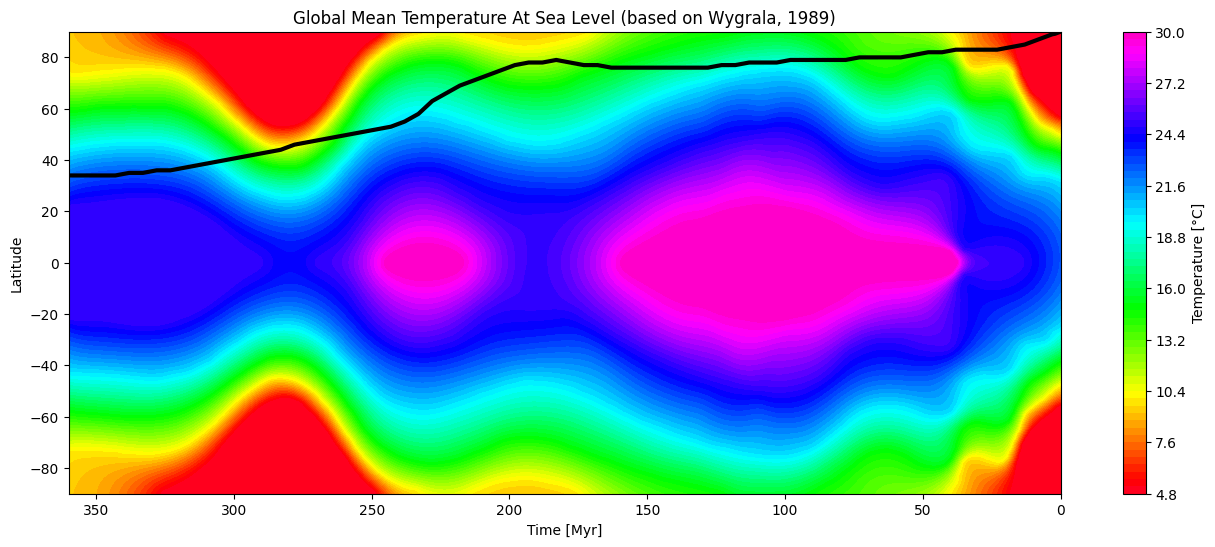

In [25]:
Lon, Lat = np.meshgrid(longitude, latitude)
plt.figure(figsize=(16, 6))
contour = plt.contourf(Lon, Lat, data_values, cmap='gist_rainbow', levels=80)

plt.plot(paleo_results["Time"], paleo_results["Paleolatitude"], color='black', lw=3)

plt.colorbar(contour, label="Temperature [°C]")

plt.xlabel("Time [Myr]")
plt.ylabel("Latitude")
plt.title("Global Mean Temperature At Sea Level (based on Wygrala, 1989)")

plt.gca().invert_xaxis()
plt.show()

#### Global eustatic curve

In [26]:
Database_Global_eustatic_curve.head(5)

,"Haq, 2005 (compiled)",Unnamed: 1,Unnamed: 2,"Haq, 1987 (long)",Unnamed: 4,Unnamed: 5,"Haq, 1987 (short)",Unnamed: 7,Unnamed: 8,"Watts, 1979",...,Unnamed: 40,Rescaled datasets used,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,Time,Relative sea level,NaN,Time,Relative sea level,NaN,Time,Relative sea level,NaN,Time,...,NaN,Time,"Haq, 2005 (compiled)","Haq, 1987 (long)","Watts, 1979","Watts, 1984","Pitman, 1978","Vail, 1978","Miller, 2005 (long)","Miller, 2008 (average)"
1,0,0,NaN,0,50,NaN,0,0,NaN,0,...,NaN,0,0,50,0,-0.5001,-0.10582,0,0,50
2,0.1,-0.92542,NaN,0.1,56.70335,NaN,0.2,72.33343,NaN,0.1,...,NaN,0.1,-0.92542,56.70335,-0.5288,-0.38433,-0.10552,0,-6.79067,54.92094
3,0.2,-0.81927,NaN,1.1,64.62095,NaN,0.3,78.56332,NaN,0.2,...,NaN,0.2,-0.81927,57.49511,-0.5285,-0.26856,-0.10522,0,-9.606015,54.92124
4,0.3,-0.71312,NaN,2.1,71.95887,NaN,0.4,82.0459,NaN,0.3,...,NaN,0.3,-0.71312,58.28687,-0.52819,-0.15279,-0.10491,0.0,-12.42136,54.92154


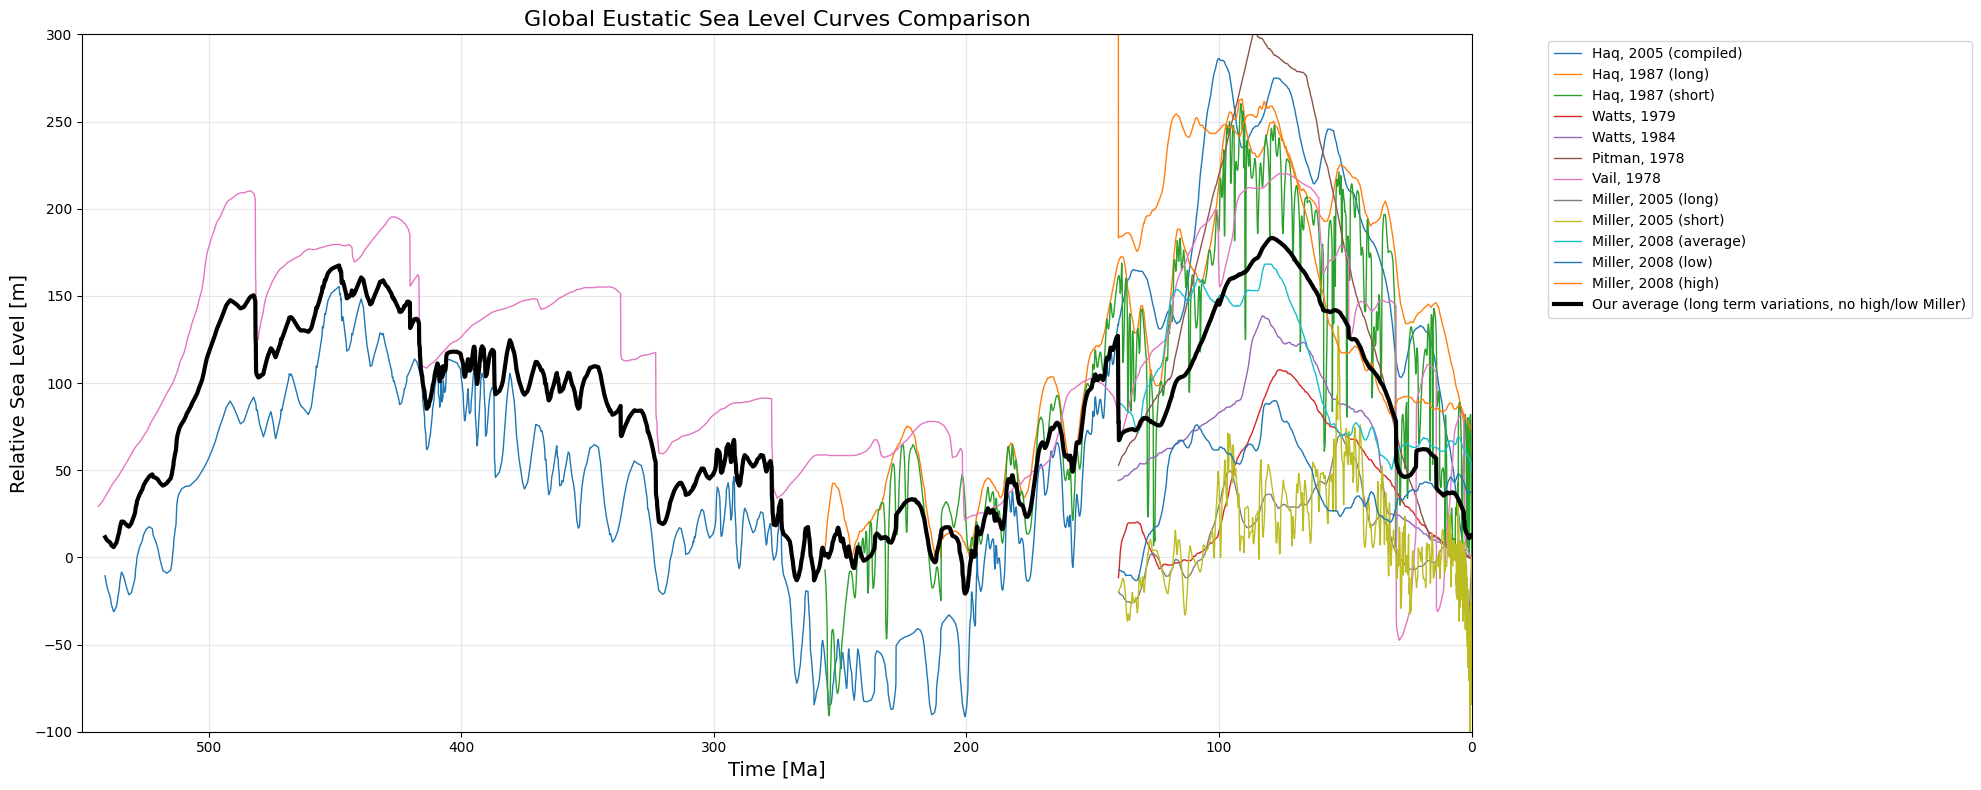

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = Database_Global_eustatic_curve

model_headers = [col for col in df.columns
                if not str(col).startswith('Unnamed')
                and "Rescaled datasets used" not in str(col)]
model_data = {}

for model in model_headers:
    start_col = df.columns.get_loc(model)

    # Extract data ensuring list format
    time = df.iloc[1:, start_col].dropna().astype(float).values
    sea_level = df.iloc[1:, start_col + 1].dropna().astype(float).values

    if len(time) == 0 or len(sea_level) == 0:
        continue

    model_df = pd.DataFrame({
        'Time': time.tolist(),
        'Relative sea level': sea_level.tolist()
    })

    if not model_df.empty:
        model_data[model] = model_df


plt.figure(figsize=(20, 8))
for model_name, data in model_data.items():
    plot_args = {
        'linewidth': 3 if "Our average" in model_name else 1,
        'color': 'black' if "Our average" in model_name else None,
        'label': model_name
    }
    plt.plot(data['Time'], data['Relative sea level'], **plot_args)


plt.xlabel('Time [Ma]', fontsize=14)
plt.ylabel('Relative Sea Level [m]', fontsize=14)
plt.title('Global Eustatic Sea Level Curves Comparison', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 550)
plt.ylim(-100, 300)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

# Layers Subdivision

In [28]:
# Кол-во слоев по которым будет проходит расчет.
# Не учитывает первый слой - Эрозию и последний - Фундамент
layers_quantity = len(df_well[1:df_well.shape[0]-1]) #amount of layers for calculation
layers_quantity

10

In [29]:
# # work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
# work_layers = df_well[1:df_well.shape[0]] ### Слои, по которым идет расчет
# work_layers_initial = work_layers.copy()
# work_layers_initial

work_layers = df_well_with_properties[1:df_well_with_properties.shape[0]] ### Слои, по которым идет расчет
work_layers_initial = work_layers.copy()
work_layers_initial

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, m",...,Ea,A,Clay Content,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options
1,Test_well,Layer 10,Erosion,Shale (typical),0,0.30,0.50,200.0,NaN,300,...,23.2,0.0,0,0,0,0,0,0,0,NaN
2,Test_well,Layer 9,Deposition,Sandstone (typical),45,0.50,0.75,250.0,NaN,325,...,23.2,0.0,0,0,0,0,0,0,0,NaN
3,Test_well,Layer 8,Deposition,Shale (typical),55,0.75,1.50,750.0,NaN,350,...,23.2,0.0,0,0,0,0,0,0,0,NaN
4,Test_well,Layer 7,Deposition,Chalk (typical),80,1.50,2.80,1300.0,NaN,300,...,23.2,0.0,0,0,0,0,0,0,0,NaN
5,Test_well,Layer 6,Deposition,Sandstone (typical),100,2.80,3.70,900.0,NaN,200,...,23.2,0.0,0,0,0,0,0,0,0,NaN
6,Test_well,Layer 5,Deposition,Limestone (ooid grainstone),125,3.70,3.90,200.0,NaN,20,...,23.2,0.0,0,0,0,0,0,0,0,NaN
7,Test_well,Layer 4,Deposition,Dolomite (typical),145,3.90,4.30,400.0,NaN,20,...,23.2,0.0,0,0,0,0,0,0,0,NaN
8,Test_well,Layer 3,Deposition,Sandstone (typical),160,4.30,4.55,250.0,NaN,10,...,23.2,0.0,0,0,0,0,0,0,0,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.55,5.30,750.0,NaN,20,...,23.2,0.0,0,0,0,0,0,0,0,NaN
10,Test_well,Layer 1,Deposition,"Sandstone (quartzite, very quartz rich)",245,5.30,5.70,400.0,NaN,0,...,23.2,0.0,0,0,0,0,0,0,0,NaN


In [30]:
work_layers['Sublayers'] = 'On'
work_layers['N sublayers'] = int(1)
# work_layers.loc[work_layers['Event_name'] == 'Layer 7', 'Sublayers'] = 'On'
# work_layers.loc[work_layers['Event_name'] == 'Layer 7', 'N sublayers'] = int(1)

/tmp/ipython-input-30-2496218272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_layers['Sublayers'] = 'On'
/tmp/ipython-input-30-2496218272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_layers['N sublayers'] = int(1)


In [31]:
work_layers[0:]

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, m",...,Ea,A,Clay Content,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options
1,Test_well,Layer 10,Erosion,Shale (typical),0,0.30,0.50,200.0,NaN,300,...,23.2,0.0,0,0,0,0,0,0,0,NaN
2,Test_well,Layer 9,Deposition,Sandstone (typical),45,0.50,0.75,250.0,NaN,325,...,23.2,0.0,0,0,0,0,0,0,0,NaN
3,Test_well,Layer 8,Deposition,Shale (typical),55,0.75,1.50,750.0,NaN,350,...,23.2,0.0,0,0,0,0,0,0,0,NaN
4,Test_well,Layer 7,Deposition,Chalk (typical),80,1.50,2.80,1300.0,NaN,300,...,23.2,0.0,0,0,0,0,0,0,0,NaN
5,Test_well,Layer 6,Deposition,Sandstone (typical),100,2.80,3.70,900.0,NaN,200,...,23.2,0.0,0,0,0,0,0,0,0,NaN
6,Test_well,Layer 5,Deposition,Limestone (ooid grainstone),125,3.70,3.90,200.0,NaN,20,...,23.2,0.0,0,0,0,0,0,0,0,NaN
7,Test_well,Layer 4,Deposition,Dolomite (typical),145,3.90,4.30,400.0,NaN,20,...,23.2,0.0,0,0,0,0,0,0,0,NaN
8,Test_well,Layer 3,Deposition,Sandstone (typical),160,4.30,4.55,250.0,NaN,10,...,23.2,0.0,0,0,0,0,0,0,0,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.55,5.30,750.0,NaN,20,...,23.2,0.0,0,0,0,0,0,0,0,NaN
10,Test_well,Layer 1,Deposition,"Sandstone (quartzite, very quartz rich)",245,5.30,5.70,400.0,NaN,0,...,23.2,0.0,0,0,0,0,0,0,0,NaN


In [32]:
# filtered_df = df_well[df_well['Event_name'] != 'Erosion']

In [33]:
df_well.iloc[-1]

,11
Well,Test_well
Event_name,Fundament
Event_type,Deposition
Lithology_type,NaN
Age (Ma),260
"Depth top, m",5.7
"Depth bottom, m",NaN
"Thickness, m",NaN
"D Thickness (erosion), m",NaN
"Paleobathymetry, m",-20


In [34]:
def layers_subdivision(work_layers, on=True):

  df_repeated = pd.DataFrame()

  if on == False:
    return work_layers

  else:

    result_df = pd.DataFrame()
    work_layers_copy = work_layers[0:].copy()

    for index, row in work_layers_copy.iterrows():
        if not pd.isnull(row['N sublayers']):
            # Calculate the interval value
            print(row['Depth bottom, m'], row['Depth top, m'], int(row['N sublayers']))
            interval = (row['Depth bottom, m'] - row['Depth top, m']) / int(row['N sublayers'])
            interval_thickness = row['Thickness, m'] / (int(row['N sublayers']))

            interval_age = 0
            next_index = index + 1
            if next_index < len(work_layers_copy):
              next_row = work_layers_copy.loc[next_index]
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))
            else:
              last_row= df_well.iloc[-1]
              next_row = last_row
              interval_age = (next_row['Age (Ma)'] - row['Age (Ma)']) / (int(row['N sublayers']))

            # Repeat the row 'div' times and append to the new DataFrame
            repeated_rows = [row.copy() for _ in range(int(row['N sublayers']))]
            for i, r in enumerate(repeated_rows):
                r['Event_name'] = row['Event_name'] + f'_{i+1}'
                r['Depth top, m'] = row['Depth top, m'] + i * interval
                r['Depth bottom, m'] = row['Depth top, m'] + (i + 1) * interval
                r['Thickness, m'] = interval_thickness
                r['Age (Ma)'] = row['Age (Ma)'] + i*interval_age
            df_repeated = pd.concat([df_repeated, pd.DataFrame(repeated_rows)], ignore_index=True)
        else:
            df_repeated = pd.concat([df_repeated, pd.DataFrame([row])], ignore_index=True)

    return df_repeated

In [35]:
valid_layers = work_layers[
    work_layers['Lithology_type'].notna() &
    (work_layers['Lithology_type'].astype(str).str.lower() != "nan")].copy() # Layers Selection with out fundament (=last layer)


In [36]:
def layers_subdivision(work_layers, on=True):
    if not on:
        return work_layers

    result_rows = []  # Store results as dictionaries instead of DataFrames

    for index, row in work_layers.iterrows():
        if not pd.isnull(row['N sublayers']):
            # Calculate subdivision parameters
            print(row['Depth bottom, m'], row['Depth top, m'], int(row['N sublayers']))
            interval = (row['Depth bottom, m'] - row['Depth top, m']) / int(row['N sublayers'])
            interval_thickness = row['Thickness, m'] / int(row['N sublayers'])

            # Calculate age increment
            next_index = index + 1
            if next_index < len(work_layers):
                next_age = work_layers.loc[next_index, 'Age (Ma)']
            else:
                next_age = work_layers.iloc[-1]['Age (Ma)']
            interval_age = (next_age - row['Age (Ma)']) / int(row['N sublayers'])

            # Create subdivided layers
            for i in range(int(row['N sublayers'])):
                new_row = row.copy()
                new_row['Event_name'] = f"{row['Event_name']}_{i+1}"
                new_row['Depth top, m'] = row['Depth top, m'] + i * interval
                new_row['Depth bottom, m'] = row['Depth top, m'] + (i + 1) * interval
                new_row['Thickness, m'] = interval_thickness
                new_row['Age (Ma)'] = row['Age (Ma)'] + i * interval_age
                result_rows.append(new_row.to_dict())  # Store as dictionary
        else:
            result_rows.append(row.to_dict())  # Store as dictionary

    # Create DataFrame from list of dictionaries
    return pd.DataFrame(result_rows)

In [37]:
work_layers = layers_subdivision(valid_layers, on=True)
work_layers.shape

0.5 0.3 1
0.75 0.5 1
1.5 0.75 1
2.8 1.5 1
3.7 2.8 1
3.9 3.7 1
4.3 3.9 1
4.55 4.3 1
5.3 4.55 1
5.7 5.3 1


(10, 173)

In [38]:
work_layers_copy_initial = work_layers.copy()

In [39]:
work_layers_copy_initial

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, m",...,Ea,A,Clay Content,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options
0,Test_well,Layer 10_1,Erosion,Shale (typical),0.0,0.30,0.50,200.0,NaN,300,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
1,Test_well,Layer 9_1,Deposition,Sandstone (typical),45.0,0.50,0.75,250.0,NaN,325,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
2,Test_well,Layer 8_1,Deposition,Shale (typical),55.0,0.75,1.50,750.0,NaN,350,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
3,Test_well,Layer 7_1,Deposition,Chalk (typical),80.0,1.50,2.80,1300.0,NaN,300,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
4,Test_well,Layer 6_1,Deposition,Sandstone (typical),100.0,2.80,3.70,900.0,NaN,200,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
5,Test_well,Layer 5_1,Deposition,Limestone (ooid grainstone),125.0,3.70,3.90,200.0,NaN,20,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
6,Test_well,Layer 4_1,Deposition,Dolomite (typical),145.0,3.90,4.30,400.0,NaN,20,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
7,Test_well,Layer 3_1,Deposition,Sandstone (typical),160.0,4.30,4.55,250.0,NaN,10,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
8,Test_well,Layer 2_1,Deposition,Anhydrite,210.0,4.55,5.30,750.0,NaN,20,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
9,Test_well,Layer 1_1,Deposition,"Sandstone (quartzite, very quartz rich)",245.0,5.30,5.70,400.0,NaN,0,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN


### Lithology

In [40]:
df_well["Lithology_type"].tolist()

[nan,
 'Shale (typical)',
 'Sandstone (typical)',
 'Shale (typical)',
 'Chalk (typical)',
 'Sandstone (typical)',
 'Limestone (ooid grainstone)',
 'Dolomite (typical)',
 'Sandstone (typical)',
 'Anhydrite',
 'Sandstone (quartzite, very quartz rich)',
 nan]

In [41]:

lithology_numbers = {30000: {'lith':'Sandstone (typical)', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone (typical)', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shale (typical)', 'lith_num':3, 'hatch':'-.. ', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite (typical)', 'lith_num':5, 'hatch':'-\\', 'color':'blue'},
                 70000: {'lith':'Limestone (ooid grainstone)', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk (typical)', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'-/', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Sandstone (quartzite, very quartz rich)', 'lith_num':11, 'hatch':'oo', 'color':'#ffe119'},
                 93000: {'lith':'nan', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}


In [42]:
# lithology_numbers = {30000: {'lith':'Sandstones', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
#                  65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
#                  65000: {'lith':'Shales', 'lith_num':3, 'hatch':'-.. ', 'color':'#bebebe'},
#                  80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
#                  74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-\\', 'color':'blue'},
#                  70000: {'lith':'Limestones', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
#                  70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
#                  88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
#                  86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'-/', 'color':'#ff80ff'},
#                  99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
#                  90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'oo', 'color':'#ffe119'},
#                  93000: {'lith':'nan', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [43]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.reset_index(inplace=True)

df_lith

,index,lith,lith_num,hatch,color
0,30000,Sandstone (typical),1,..,#ffff00
1,65030,Sandstone (typical),2,-.,#ffe119
2,65000,Shale (typical),3,-..,#bebebe
3,80000,Marl,4,,#7cfc00
4,74000,Dolomite (typical),5,-\,blue
5,70000,Limestone (ooid grainstone),6,+,#80ffff
6,70032,Chalk (typical),7,..,#80ffff
7,88000,Halite,8,x,#7ddfbe
8,86000,Anhydrite,9,-/,#ff80ff
9,99000,Tuff,10,||,#ff8c00


In [44]:
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, m",...,Ea,A,Clay Content,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options
0,Test_well,Layer 10_1,Erosion,Shale (typical),0.0,0.30,0.50,200.0,NaN,300,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
1,Test_well,Layer 9_1,Deposition,Sandstone (typical),45.0,0.50,0.75,250.0,NaN,325,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
2,Test_well,Layer 8_1,Deposition,Shale (typical),55.0,0.75,1.50,750.0,NaN,350,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
3,Test_well,Layer 7_1,Deposition,Chalk (typical),80.0,1.50,2.80,1300.0,NaN,300,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
4,Test_well,Layer 6_1,Deposition,Sandstone (typical),100.0,2.80,3.70,900.0,NaN,200,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
5,Test_well,Layer 5_1,Deposition,Limestone (ooid grainstone),125.0,3.70,3.90,200.0,NaN,20,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
6,Test_well,Layer 4_1,Deposition,Dolomite (typical),145.0,3.90,4.30,400.0,NaN,20,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
7,Test_well,Layer 3_1,Deposition,Sandstone (typical),160.0,4.30,4.55,250.0,NaN,10,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
8,Test_well,Layer 2_1,Deposition,Anhydrite,210.0,4.55,5.30,750.0,NaN,20,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN
9,Test_well,Layer 1_1,Deposition,"Sandstone (quartzite, very quartz rich)",245.0,5.30,5.70,400.0,NaN,0,...,23.2,1.110000e-10,0,0,0,0,0,0,0,NaN


In [45]:
lithology_array = []
hatch_array = []
color_array = []

for row_index, row in enumerate(work_layers.itertuples()):
    lithology = work_layers.at[row.Index, 'Lithology_type']
    layers_name = work_layers.at[row.Index, 'Event_name']

    lit_num = df_lith.loc[df_lith['lith'] == str(lithology), 'index'].iloc[0]
    lithology_array.append(lit_num)

    hatch_val = df_lith.loc[df_lith['lith'] == str(lithology), 'hatch'].iloc[0]
    hatch_array.append(hatch_val)

    color_val = df_lith.loc[df_lith['lith'] == str(lithology), 'color'].iloc[0]
    color_array.append(color_val)

work_layers["Lithology"] = lithology_array
work_layers["Index"] = hatch_array
work_layers["Color"] = color_array
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, m",...,Porosity Opal A- opal CT,Permeability Opal A- Opal CT,Capillary Pressure Opal A-opal CT,Porosity Opal CT-Quartz,Permeability Opal CT - Quartz,Capillary pressure Opal CT - Quartz,Special options,Lithology,Index,Color
0,Test_well,Layer 10_1,Erosion,Shale (typical),0.0,0.30,0.50,200.0,NaN,300,...,0,0,0,0,0,0,NaN,65000,-..,#bebebe
1,Test_well,Layer 9_1,Deposition,Sandstone (typical),45.0,0.50,0.75,250.0,NaN,325,...,0,0,0,0,0,0,NaN,30000,..,#ffff00
2,Test_well,Layer 8_1,Deposition,Shale (typical),55.0,0.75,1.50,750.0,NaN,350,...,0,0,0,0,0,0,NaN,65000,-..,#bebebe
3,Test_well,Layer 7_1,Deposition,Chalk (typical),80.0,1.50,2.80,1300.0,NaN,300,...,0,0,0,0,0,0,NaN,70032,..,#80ffff
4,Test_well,Layer 6_1,Deposition,Sandstone (typical),100.0,2.80,3.70,900.0,NaN,200,...,0,0,0,0,0,0,NaN,30000,..,#ffff00
5,Test_well,Layer 5_1,Deposition,Limestone (ooid grainstone),125.0,3.70,3.90,200.0,NaN,20,...,0,0,0,0,0,0,NaN,70000,+,#80ffff
6,Test_well,Layer 4_1,Deposition,Dolomite (typical),145.0,3.90,4.30,400.0,NaN,20,...,0,0,0,0,0,0,NaN,74000,-\,blue
7,Test_well,Layer 3_1,Deposition,Sandstone (typical),160.0,4.30,4.55,250.0,NaN,10,...,0,0,0,0,0,0,NaN,30000,..,#ffff00
8,Test_well,Layer 2_1,Deposition,Anhydrite,210.0,4.55,5.30,750.0,NaN,20,...,0,0,0,0,0,0,NaN,86000,-/,#ff80ff
9,Test_well,Layer 1_1,Deposition,"Sandstone (quartzite, very quartz rich)",245.0,5.30,5.70,400.0,NaN,0,...,0,0,0,0,0,0,NaN,90000,oo,#ffe119


/tmp/ipython-input-46-1546355783.py:14: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  ax.fill_betweenx(y, 0, 1, facecolor='none',


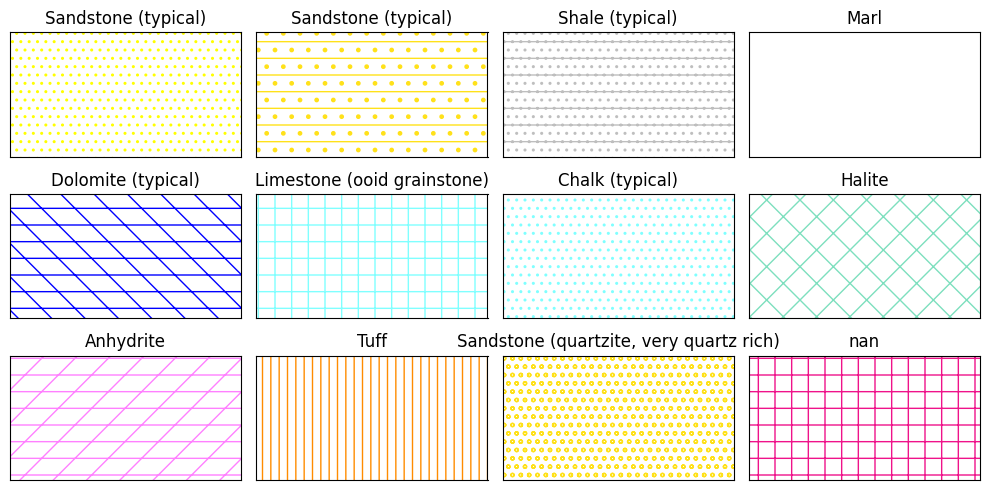

In [46]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
  ax.plot(x, y)
  if lithology_numbers[key]['lith'] == 'Shales':
    ax.fill_betweenx(y, 0, 1, facecolor='none', edgecolor='gray', hatch='_-_')

  else:
      # ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.fill_betweenx(y, 0, 1, facecolor='none',
                    edgecolor=lithology_numbers[key]['color'],         # Hatch color
                    hatch=lithology_numbers[key]['hatch'],  # e.g., '--', '..', 'xx'
                    linewidth=0.5              # Controls hatch thickness
  )

  ax.set_xlim(0, 0.1)
  ax.set_ylim(0, 1)
  ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()

## Decompacted Thickness, Porosity \& Permeability, Density



Step 1. Decompaction (decompacted thickness).

Step 2. Correction for paleobathymetry and eustasy (Decompacted depth with corrction).

Step 3. Removal effect of sediment load (porosity, permeability density).




In [47]:
# import numpy as np
# from scipy.special import lambertw

# def decomp_func(y1, y2, y1_d, phi, c):  # возвращает фун-ию одной переменной, для которой затем подбирается параметр y2_d

#     y2_d = (np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) - \
#             np.exp(-np.log(e) * y1 * c) * phi * np.log(e) + \
#             np.exp(-np.log(e) * y2 * c) * phi * np.log(e) - \
#             np.log(e) * y1 * c + np.log(e) * y1_d * c + np.log(e) * y2 * c + \
#             lambertw(-np.log(e) * phi * np.exp(-np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) +\
#                                                np.exp(-np.log(e) * y1 * c) * phi * np.log(e) - \
#                                                np.exp(-np.log(e) * y2 * c) * phi * np.log(e) + \
#                                                np.log(e) * y1 * c - \
#                                                np.log(e) * y1_d * c - np.log(e) * y2 * c))) / c / np.log(e)
#     return y2_d.real

In [48]:
import numpy as np
from scipy.optimize import fsolve

def decompaction_formula(y2_prime, y1, y2, y1_prime, phi0, c):
    """
    Solves the decompaction equation iteratively to find y2'

    Parameters:
    y2_prime : decompacted base depth (to solve for)
    y1 : original top depth
    y2 : original base depth
    y1_prime : decompacted top depth
    phi0 : initial porosity
    c : compaction coefficient

    Returns:
    Difference between LHS and RHS (to be minimized)
    """
    # Original layer properties
    original_thickness = y2 - y1
    avg_phi_original = phi0 * (np.exp(-c*y1) - np.exp(-c*y2)) / (c*(y2-y1))
    original_solid_thickness = original_thickness * (1 - avg_phi_original)

    # Decompacted layer properties
    decompacted_thickness = y2_prime - y1_prime
    avg_phi_decompacted = phi0 * (np.exp(-c*y1_prime) - np.exp(-c*y2_prime)) / (c*(y2_prime-y1_prime))
    decompacted_solid_thickness = decompacted_thickness * (1 - avg_phi_decompacted)

    # Equation to solve: solid thickness should be equal before/after decompaction
    return original_solid_thickness - decompacted_solid_thickness

def decomp_func(y1, y2, y1_prime, phi0, c):
    """
    Wrapper function to solve for y2_prime using numerical methods
    """
    # Initial guess for y2_prime (slightly thicker than original)
    initial_guess = y1_prime + 1*(y2 - y1)
    # initial_guess = y1_prime  + (y2- y1)

    # Solve numerically
    y2_prime = fsolve(
        lambda y2p: decompaction_formula(y2p, y1, y2, y1_prime, phi0, c),
        initial_guess
    )[0]

    return y2_prime

In [49]:
def porosity_func(phi0, c, y1, y2, thickness):
    """
    Calculate average porosity between y1 and y2
    """
    if thickness == 0:
        return 0
    integral = phi0 * (np.exp(-c*y1) - np.exp(-c*y2)) / c
    return integral / thickness

In [50]:
#считает скорректированную декомпактированную глубину
def corrected(depth, RoMantle, RoWater, PWD, eustatic):
  return depth - eustatic * (RoWater / (RoMantle - RoWater)) + (PWD - eustatic)

In [51]:
def bulk_density(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [52]:
def bulk_density_column(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [53]:
def tectonic_subsidence (RoMantle, RoWater, RoColumn, depth):
  return depth*((RoMantle-RoColumn)/(RoMantle-RoWater))

In [54]:
def Kozeny_Carman(r, phi, tau):
    return r**2 * phi / (8 * tau**2)

def Kozeny_Carman_lithology(phi, S, k):
    phi_corrected = phi - 3.1 * 10e-10
    if phi_corrected < 0.1:
        return 2 * 10**16 * k * (phi_corrected**5 / (S**2 * (1 - phi_corrected)**2))
    else:
        return 2 * 10**14 * k * (phi_corrected**3 / (S**2 * (1 - phi_corrected)**2))

In [55]:
def sedimentationrate(depth, age):
  return depth / (age if age != 0 else 1e20)

In [56]:
def hydrostatic_pressures(depths, sea_level, sediment_surface, water_depth, rho_water=1040):

    """
    Calculate cumulative hydrostatic pressures for each layer.

    Parameters:
    - depths: List or array of bottom depth of each layer (m)
    - water_depth: Depth of water (m)
    - sediment_surface: Depth of sediment surface (m)
    - rho_water: Constant value of sea water density (kg/m^3)

    Returns:
    - List of cumulative pressures (MPa) for each layer and depth array
    """

    g = 9.81  # acceleration due to gravity in m/s^2
    pressures = [quad(lambda z: rho_water * g, sea_level, depth)[0] / 1e6 for depth in depths]  # Convert Pa to MPa

    return pressures

In [57]:
def lithostatic_pressures(layer_bottom_depth, rock_densities, porosities, sea_level,
                          water_depth, sediment_surface):
    """
    Calculate cumulative lithostatic pressures for each layer.

    Parameters:
    - layer_thicknesses: List or array of thicknesses of each layer (m)
    - rock_densities: List or array of densities of each rock layer (kg/m^3)
    - porosities: List or array of porosity values for each layer (fraction)
    - water_depth: Constant value of a water depth (m)

    Returns:
    - List of cumulative pressures (MPa) for each layer
    """
    g = 9.81  # acceleration due to gravity in m/s^2
    rho_sea = 1100
    pressures = []
    total_depth = 0
    total_pressure = 0

    if sediment_surface < 0:

      filtered_depths = np.insert(layer_bottom_depth, 0, sediment_surface)
      rock_densities = np.insert(rock_densities, 0, 0)
      porosities = np.insert(porosities, 0, 0)    # Add sediment porosity at the start


      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):
        total_pressure = 0
        effective_density = density * (1 - porosity) + rho_sea*porosity

        water_pressure = rho_sea * g * water_depth
        pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
        total_pressure += water_pressure
        total_pressure += pressure_increment

        pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

    else:

      filtered_depths = [depth for depth in layer_bottom_depth if depth > sediment_surface]
      filtered_depths.insert(0, sediment_surface)

      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):

          total_pressure = 0
          effective_density = density * (1 - porosity) + rho_sea*porosity

          water_pressure = rho_sea * g * water_depth
          pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
          total_pressure += water_pressure
          total_pressure += pressure_increment

          pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

Chech parametrs for lithology in **Database_Lithotypes**

In [58]:
sandstone_row = Database_Lithotypes[Database_Lithotypes['Lithology type'] == 'Anhydrite']
sandstone_row.columns

# Find all columns containing 'exp' (case-insensitive)
exp_columns = [
    col for col in sandstone_row.columns
    if pd.notna(col) and 'adiogenic' in str(col).lower()
]

if exp_columns:
    print("✅ Columns containing :")
    for col in exp_columns:
        print(f"- {col}")
else:
    print("❌ No columns contain")

✅ Columns containing :
- Radiogenic model key


Reference

In [59]:
import numpy as np
import pandas as pd

# ========== CONSTANTS & INITIALIZATION ==========

# Add these constants at the top with your other constants
DEFAULT_R = 1e6    # Grain radius
DEFAULT_TAU = 1.5  # Tortuosity factor
DEFAULT_S = 1e6    # Specific surface area (m²/m³)
DEFAULT_K = 1      # Permeability factor

LITHOLOGY_S_VALUES = {
    "Shale (typical)": 1e10,          # High S for shales (organic-rich, fine-grained)
    "Sandstone (typical)": 1e5,      # Moderate S for sandstones
    "Chalk (typical)": 1e20,         # Extremely high S (nanoporous)
    "Limestone (organic rich - typical)": 1e6,  # High S due to organic content
    "Dolomite (typical)": 1e10,      # Very high S (crystalline porosity)
    "Anhydrite": 1e20,               # Extremely low permeability
    "Quartzite": 1e20                # Dense, low-permeability
}

# Prepare age list
valid_layers = work_layers[
    work_layers['Lithology_type'].notna() &
    (work_layers['Lithology_type'].astype(str).str.lower() != "nan")].copy() # Layers Selection with out fundament (=last layer)

# Get unique ages from the valid layers (oldest first)
age_list = sorted(valid_layers['Age (Ma)'].unique(), reverse=False)

# Constants
RoWater, RoMantle = 1000, 3300

In [108]:
# ========== CONSTANTS & INITIALIZATION ==========
# Precompute lithology parameters with updated S value handling
lithology_params = {}
for lith in Database_Lithotypes['Lithology type'].unique():
    lith_data = Database_Lithotypes[Database_Lithotypes['Lithology type'] == lith].iloc[0]

    # Find best matching S value - checks exact matches first, then contains, then default
    S_value = None
    for pattern in LITHOLOGY_S_VALUES:
        if pattern.lower() in lith.lower():
            S_value = LITHOLOGY_S_VALUES[pattern]
            break

    params = {
        'phi0': lith_data['Initial porosity'] / 100,
        'c': 1e-20 if lith_data['Athy factor k (depth)'] == 0 else lith_data['Athy factor k (depth)'],
        'RoGrain': lith_data['Density'],
        'Grain_radius': lith_data['Grain radius (m)'] if 'Grain radius (m)' in lith_data else DEFAULT_R,
        'Tortuosity': lith_data['Tortuosity'] if 'Tortuosity' in lith_data and not pd.isna(lith_data['Tortuosity']) else DEFAULT_TAU,
        'Specific_surface': (lith_data['Specific surface']
                             if 'Specific surface' in lith_data and not pd.isna(lith_data['Specific surface']) and lith_data['Specific surface'] > 0
                             else (S_value if S_value is not None else DEFAULT_S)),
        'Permeability_factor': lith_data['Permeability factor'] if 'Permeability factor' in lith_data else DEFAULT_K,
        'Bulk_modulus': lith_data['Constant Value 2'] if 'Constant Value 2' in lith_data else 37,
        'Shear_modulus': lith_data['Shear Modulus'] if 'Shear Modulus' in lith_data else 44
    }
    lithology_params[lith] = params

valid_layers['phi0'] = valid_layers['Lithology_type'].map(lambda x: lithology_params.get(x, {}).get('phi0', 0))
valid_layers['c'] = valid_layers['Lithology_type'].map(lambda x: lithology_params.get(x, {}).get('c', 1e-20))
valid_layers['RoGrain'] = valid_layers['Lithology_type'].map(lambda x: lithology_params.get(x, {}).get('RoGrain', 0))
valid_layers['PWD_km'] = valid_layers['Paleobathymetry, m'] / 1000
valid_layers['eustatic_km'] = valid_layers['Sea level, m'] / 1000

num_layers = valid_layers.shape[0]
result_dfs = {
    'decompaction': pd.DataFrame(index=range(num_layers)),
    'decompaction_corrected': pd.DataFrame(index=range(num_layers)),
    'thickness': pd.DataFrame(index=range(num_layers)),
    'porosity': pd.DataFrame(index=range(num_layers)),
    'density': pd.DataFrame(index=range(num_layers)),
    'permeability': pd.DataFrame(index=range(num_layers)),
    'sedimentation_rate': pd.DataFrame(index=range(num_layers)),
    'vp': pd.DataFrame(index=range(num_layers)),
    'vs': pd.DataFrame(index=range(num_layers)),
    'density_column': pd.DataFrame(index=[0]),
    'hydrostatic_pressure': pd.DataFrame(index=range(num_layers)),
    'lithostatic_pressure': pd.DataFrame(index=range(num_layers)),
    'sediment_surface': pd.DataFrame(index=range(num_layers), columns=['0.0'])
}

g = 9.81
rho_sea = 1100
rho_w = 1040
RoWater = 1000
RoMantle = 3300

def hydrostatic_pressures(depths_m, sea_level, sediment_surface, water_depth, rho_water=rho_w):
    pressures = []
    for depth in depths_m:
        if sediment_surface >= sea_level:
            water_pressure = rho_sea * g * water_depth
            sediment_pressure = rho_water * g * max(0, depth - sediment_surface)
        else:
            water_pressure = 0
            sediment_pressure = rho_water * g * (depth - sea_level)
        pressures.append((water_pressure + sediment_pressure) / 1e6)
    return pressures

def lithostatic_pressures(depths_m, densities, porosities, sea_level, water_depth, sediment_surface):
    pressures = []
    total_pressure = rho_sea * g * water_depth if sediment_surface >= sea_level else 0

    for i, depth in enumerate(depths_m):
        start_depth = sediment_surface if i == 0 else depths_m[i-1]
        layer_thickness = depth - start_depth
        effective_density = densities[i] * (1 - porosities[i]) + rho_w * porosities[i]
        total_pressure += effective_density * g * layer_thickness
        pressures.append(total_pressure / 1e6)
    return pressures

def process_layer(row, current_depth, current_depth_corrected):
    lithology = row['Lithology_type']
    lith_params = lithology_params.get(lithology, {})

    S = max(lith_params.get('Specific_surface', DEFAULT_S), 1e-20)
    k_factor = lith_params.get('Permeability_factor', DEFAULT_K)
    K = lith_params.get('Bulk_modulus', 37)
    G = lith_params.get('Shear_modulus', 44)

    decompacted_top = current_depth
    decompacted_bottom = decomp_func(
        row['Depth top, m'],
        row['Depth bottom, m'],
        decompacted_top,
        row['phi0'],
        row['c']
    )

    corrected_top = corrected(decompacted_top, RoMantle, RoWater, row['PWD_km'], row['eustatic_km'])
    corrected_bottom = corrected(decompacted_bottom, RoMantle, RoWater, row['PWD_km'], row['eustatic_km'])

    thickness = decompacted_bottom - decompacted_top
    porosity = porosity_func(row['phi0'], row['c'], decompacted_top, decompacted_bottom, thickness)
    density = bulk_density(porosity, row['RoGrain'], RoWater)
    density_column = density * thickness
    permeability = Kozeny_Carman_lithology(porosity, S, k_factor)


    if density > 0:
        v_p = np.sqrt((K*1e6 + (4/3)*G*1e6) / density) / 1000
        v_s = np.sqrt(G*1e6 / density) / 1000
    else:
        v_p = v_s = 0

    return {
        'decompacted_top': decompacted_top,
        'decompacted_bottom': decompacted_bottom,
        'corrected_top': corrected_top,
        'corrected_bottom': corrected_bottom,
        'thickness': thickness,
        'porosity': porosity,
        'density': density,
        'density_column': density_column,
        'permeability': permeability,
        'v_p': np.round(v_p, 3),
        'v_s': np.round(v_s, 3),
        'new_depth': decompacted_bottom,
        'new_corrected_depth': corrected_bottom,
        'sediment_surface': valid_layers.iloc[i]['Paleobathymetry, m']
    }

def pad_results(values, total_layers):
    padded = np.zeros(total_layers)
    if len(values) > 0:
        padded[-len(values):] = values
    return padded

for i, age in enumerate(age_list):
    current_depth = current_depth_corrected = 0
    results = {
        'decompacted': [], 'corrected': [], 'thickness': [],
        'porosity': [], 'density': [], 'density_column': [],
        'permeability': [], 'sedimentation_rate': [], 'vp': [], 'vs': [],
        'decompacted_bottoms': [], 'sediment_surface': []
    }

    sediment_surface_m = valid_layers.iloc[i]['Paleobathymetry, m']
    sea_level = 0

    for _, row in valid_layers.iloc[i:].iterrows():
        try:
            layer_result = process_layer(row, current_depth, current_depth_corrected)
            current_depth = layer_result['new_depth']
            current_depth_corrected = layer_result['new_corrected_depth']

            results['decompacted'].append(layer_result['decompacted_top'])
            results['corrected'].append(layer_result['corrected_top'])
            results['thickness'].append(layer_result['thickness'])
            results['porosity'].append(layer_result['porosity'])
            results['density'].append(layer_result['density'])
            results['density_column'].append(layer_result['density_column'])
            results['permeability'].append(layer_result['permeability'])
            results['vp'].append(layer_result['v_p'])
            results['vs'].append(layer_result['v_s'])
            results['decompacted_bottoms'].append(layer_result['decompacted_bottom'])

            results['sedimentation_rate'].append(
                sedimentationrate(layer_result['thickness'], age-45) * 1e3
            )
        except Exception as ex:
            print(f"Error processing layer: {str(ex)}")
            continue

    if results['decompacted_bottoms']:
        decompacted_bottoms_m = [b * 1000 for b in results['decompacted_bottoms']]
        water_depth = sediment_surface_m if sediment_surface_m >= 0 else 0

        hydro_pressures = hydrostatic_pressures(
            decompacted_bottoms_m,
            sea_level,
            sediment_surface_m,
            water_depth
        )

        litho_pressures = lithostatic_pressures(
            decompacted_bottoms_m,
            results['density'],
            results['porosity'],
            sea_level,
            water_depth,
            sediment_surface_m
        )

        results['hydro_pressure'] = hydro_pressures
        results['litho_pressure'] = litho_pressures

    total_thickness = sum(results['thickness'])
    density_column_total = sum(results['density_column']) / total_thickness if total_thickness > 0 else 0

    col_name = f'{age}'
    result_dfs['decompaction'][col_name] = pad_results(results['decompacted'], num_layers)
    result_dfs['decompaction_corrected'][col_name] = pad_results(results['corrected'], num_layers)
    result_dfs['thickness'][col_name] = pad_results(results['thickness'], num_layers)
    result_dfs['porosity'][col_name] = pad_results(results['porosity'], num_layers)
    result_dfs['density'][col_name] = pad_results(results['density'], num_layers)
    result_dfs['permeability'][col_name] = pad_results(results['permeability'], num_layers)
    result_dfs['sedimentation_rate'][col_name] = pad_results(results['sedimentation_rate'], num_layers)
    result_dfs['vp'][col_name] = pad_results(results['vp'], num_layers)
    result_dfs['vs'][col_name] = pad_results(results['vs'], num_layers)
    result_dfs['density_column'][col_name] = [density_column_total]

    result_dfs['sediment_surface'].loc[i, '0.0'] = valid_layers.iloc[i]['Paleobathymetry, m']

    if 'hydro_pressure' in results:
        result_dfs['hydrostatic_pressure'][col_name] = pad_results(results['hydro_pressure'], num_layers)
        result_dfs['lithostatic_pressure'][col_name] = pad_results(results['litho_pressure'], num_layers)

## Function to save to csv

In [109]:
def save_to_csv(pd_name, work_layers, output_filename):
    """
    Save DataFrame to CSV with additional event and lithology information.

    Args:
        pd_name (pd.DataFrame): Main DataFrame to save
        work_layers (pd.DataFrame): DataFrame containing additional columns to merge
        output_filename (str): Path/filename for the output CSV

    Returns:
        None (saves file to disk)
    """
    if not isinstance(pd_name, pd.DataFrame):
        result_df = pd.DataFrame(pd_name)
    else:
        result_df = pd_name.copy()

    if 'Event_name' in work_layers.columns:
        result_df['Event_name'] = work_layers['Event_name']
    if 'Lithology_type' in work_layers.columns:
        result_df['Lithology_type'] = work_layers['Lithology_type']

    result_df = result_df.iloc[:, ::-1]
    result_df.to_csv(str(output_filename), index=True)

    return result_df

In [110]:
result_types = {
    'decompaction': 'decompaction_results.csv',
    'decompaction_corrected': 'decompaction_corrected_results.csv',
    'thickness': 'thickness_results.csv',
    'porosity': 'porosity_results.csv',
    'density': 'density_results.csv',
    'permeability': 'permeability_results.csv',
    'sedimentation_rate': 'sedimentation_rate_results.csv',
    'vp': 'vp_results.csv',
    'vs': 'vs_results.csv',
    'hydrostatic_pressure': 'hydrostatic_pressure_results.csv',
    'lithostatic_pressure': 'lithostatic_pressure_results.csv'
}

# Save all results except density_column
for key, filename in result_types.items():
    save_to_csv(result_dfs[key], work_layers, filename)

# Handle density_column separately
density_df = pd.DataFrame(result_dfs['density_column'])
density_df['Event_name'] = work_layers['Event_name']
density_df['Lithology_type'] = work_layers['Lithology_type']
density_df = density_df.iloc[:, ::-1]
density_df.to_csv('density_column_results.csv', index=True)

## Permeability Results & Visualization

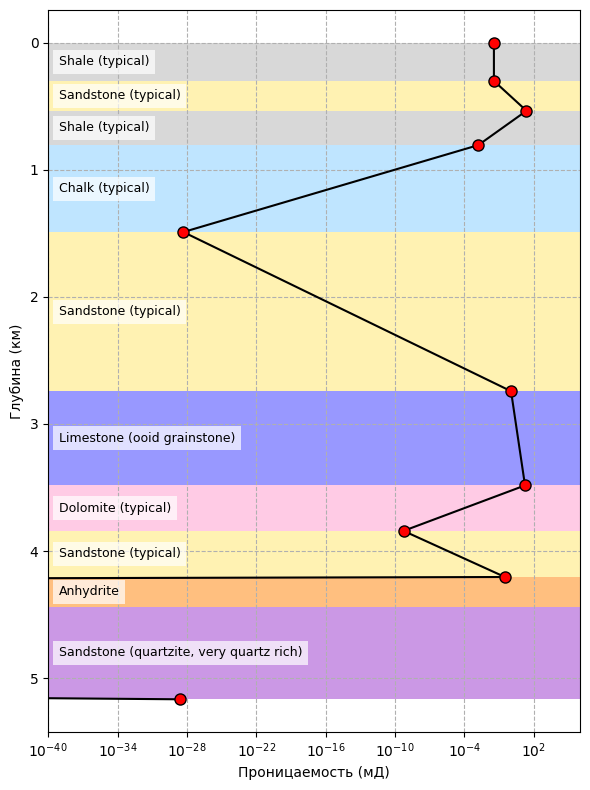

In [102]:
import matplotlib.pyplot as plt
import numpy as np

def plot_permeability_depth_profile(
    permeability_df,
    decompaction_corrected_df,
    ylim=None,
    yticks=None,
    xlim=None,
    xticks=None
):
    age_0_col = '0.0'
    permeability_age_0 = permeability_df[age_0_col].values
    depths = decompaction_corrected_df[age_0_col].values

    if depths[0] != 0:
        depths = np.insert(depths, 0, 0)
        permeability_age_0 = np.insert(permeability_age_0, 0, permeability_age_0[0])

    if 'Lithology_type' in permeability_df.columns:
        geological_layer_names = permeability_df['Lithology_type'].tolist()
    else:
        geological_layer_names = [
            'Shale (typical)',
            'Sandstone (typical)',
            'Shale (typical)',
            'Chalk (typical)',
            'Sandstone (typical)',
            'Limestone (ooid grainstone)',
            'Dolomite (typical)',
            'Sandstone (typical)',
            'Anhydrite',
            'Sandstone (quartzite, very quartz rich)'
        ]

    fig, ax = plt.subplots(figsize=(6, 8))

    # Define base colors for lithology types
    lithology_color_map = {
        'Shale (typical)': (0.7, 0.7, 0.7, 0.5),
        'Sandstone (typical)': (1.0, 0.9, 0.4, 0.5),
        'Chalk (typical)': (0.5, 0.8, 1.0, 0.5),
        'Limestone (ooid grainstone)': (0.2, 0.2, 1.0, 0.5),
        'Dolomite (typical)': (1.0, 0.6, 0.8, 0.5),
        'Anhydrite': (1.0, 0.5, 0.0, 0.5),
        'Sandstone (quartzite, very quartz rich)': (0.6, 0.2, 0.8, 0.5)
    }

    # Create color sequence maintaining consistency for repeated lithologies
    used_lithologies = {}
    color_sequence = []
    for lith in geological_layer_names:
        if lith not in used_lithologies:
            used_lithologies[lith] = lithology_color_map.get(lith, (0.8, 0.8, 0.8, 0.5))
        color_sequence.append(used_lithologies[lith])

    for i in range(len(depths)-1):
        layer_name = geological_layer_names[i]
        ax.axhspan(depths[i], depths[i+1],
                  facecolor=color_sequence[i],
                  edgecolor='none')
        ax.text(0.02, (depths[i] + depths[i+1])/2, layer_name,
                va='center', ha='left', fontsize=9, color='black',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
                transform=ax.get_yaxis_transform())

    ax.plot(permeability_age_0, depths, 'ko-',
            markersize=8, linewidth=1.5,
            markerfacecolor='red', markeredgecolor='black')

    ax.set_xscale('log')
    ax.set_xlabel('Проницаемость (мД)')
    ax.set_ylabel('Глубина (км)')
    ax.grid(True, which="both", ls="--")
    ax.invert_yaxis()

    if ylim: ax.set_ylim(ylim)
    if xlim: ax.set_xlim(xlim)
    # if xticks:
    #     ax.set_xticks(xticks)
    #     ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    plt.tight_layout()
    plt.savefig('Permeability0_vs_Depth.tiff', format='tiff', dpi=300, bbox_inches='tight')
    plt.show()

# Usage example:
plot_permeability_depth_profile(
    pd.read_csv('permeability_results.csv', index_col=0),
    pd.read_csv('decompaction_corrected_results.csv', index_col=0),
    # ylim=(5, 0),  # From 5 km to surface (0 km)
    yticks=np.arange(0, 6.0, 0.5),  # Ticks every 0.5 km
    xlim=(1e-40, 1e6),  # Permeability range
    # xticks=np.logspace(-36, 6, num=9)  # 9 logarithmic ticks from 1e-36 to 1e6
)

## Hydro & Lithostatic Pressures

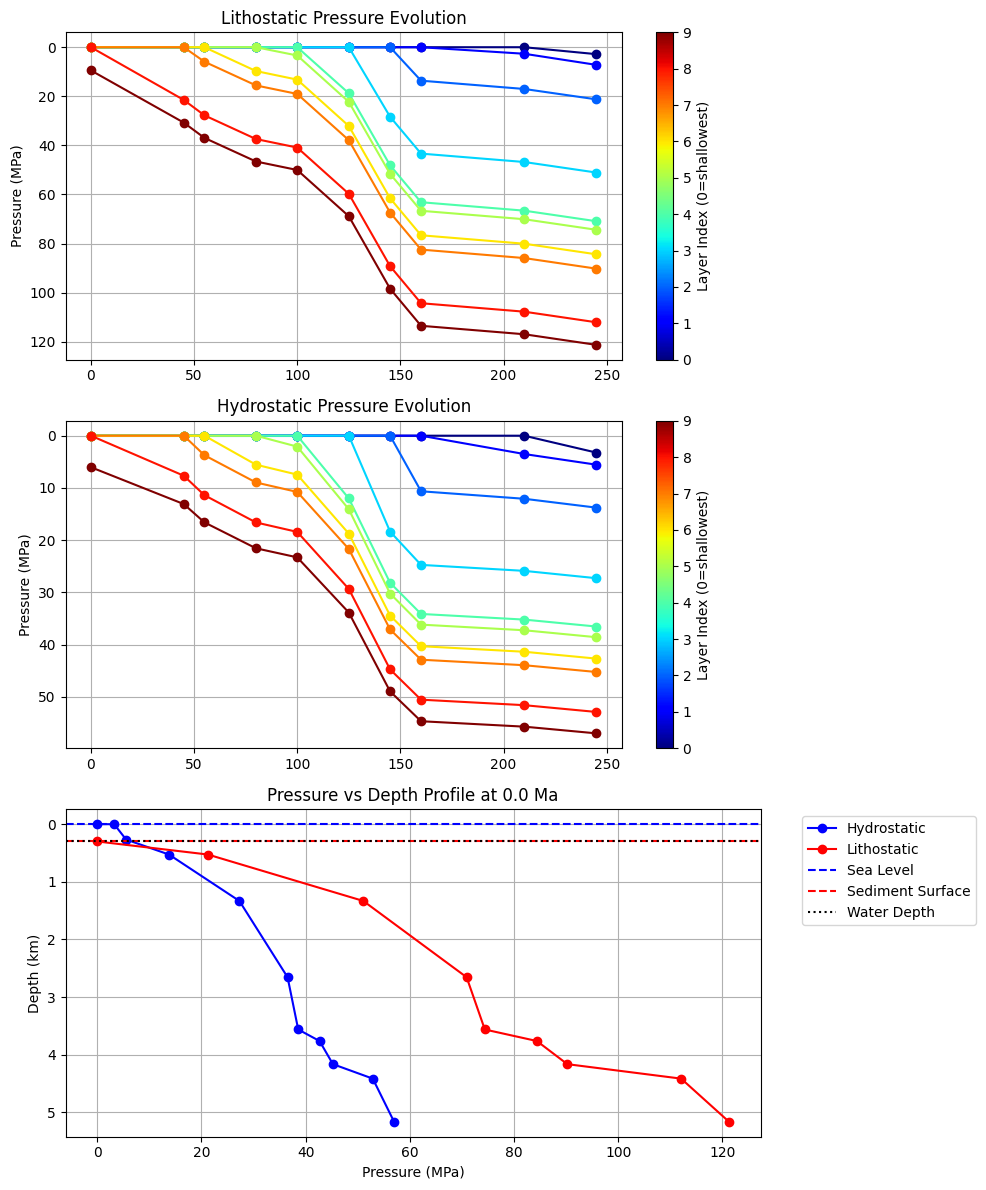

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_pressure_profiles(lithostatic_df, hydrostatic_df, decompaction_df, sediment_surfaces):
    """Plot pressure evolution and current pressure-depth profile.

    Args:
        lithostatic_df: DataFrame of lithostatic pressure values (layers × ages)
        hydrostatic_df: DataFrame of hydrostatic pressure values (layers × ages)
        decompaction_df: DataFrame of decompacted depths (layers × ages)
        sediment_surfaces: DataFrame of sediment surface elevations
    """
    ages = sorted(lithostatic_df.columns.astype(float), reverse=False)
    current_age = '0.0'

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
    colormap = plt.colormaps['jet']

    # --- Pressure Evolution Plots ---
    for ax, df, title in zip([ax1, ax2],
                            [lithostatic_df, hydrostatic_df],
                            ['Lithostatic Pressure Evolution', 'Hydrostatic Pressure Evolution']):

        norm = Normalize(vmin=0, vmax=len(df)-1)

        for idx, (layer, pressures) in enumerate(df.iterrows()):
            color = colormap(norm(idx))
            ax.plot(ages, pressures, color=color, lw=1.5, marker='o', markersize=6)

        ax.set_ylabel('Pressure (MPa)')
        ax.set_title(title)
        ax.invert_yaxis()
        ax.grid(True)

        sm = cm.ScalarMappable(cmap=colormap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, ticks=range(len(df)))
        cbar.set_label("Layer Index (0=shallowest)")

    # --- Current Pressure-Depth Profile ---
    sea_level = 0
    sediment_surface = sediment_surfaces.loc[0, current_age] / 1000
    water_depth = max(sediment_surface, sea_level)

    litho_pressures = lithostatic_df[current_age]
    hydro_pressures = hydrostatic_df[current_age]
    depths = decompaction_df[current_age]

    # Hydrostatic profile (water column + subsurface)
    hydro_mask = depths >= sea_level
    hydro_depths = np.concatenate([[sea_level], depths[hydro_mask]])
    hydro_line = np.concatenate([[0], hydro_pressures[hydro_mask]])
    ax3.plot(hydro_line, hydro_depths, 'b-', marker='o', label='Hydrostatic')

    # Lithostatic profile (sediment column)
    litho_mask = depths > sediment_surface if sediment_surface >= sea_level else depths >= sediment_surface
    litho_depths = np.concatenate([[sediment_surface], depths[litho_mask]])
    litho_line = np.concatenate([[0], litho_pressures[litho_mask]])
    ax3.plot(litho_line, litho_depths, 'r-', marker='o', label='Lithostatic')

    # Reference lines
    ax3.axhline(sea_level, color='blue', ls='--', label='Sea Level')
    ax3.axhline(sediment_surface, color='red', ls='--', label='Sediment Surface')
    if sediment_surface > sea_level:
        ax3.axhline(water_depth, color='black', ls=':', label='Water Depth')

    ax3.set_title(f'Pressure vs Depth Profile at {current_age} Ma')
    ax3.set_xlabel('Pressure (MPa)')
    ax3.set_ylabel('Depth (km)')
    ax3.invert_yaxis()
    ax3.grid(True)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

#Usage:
plot_pressure_profiles(pd.read_csv('lithostatic_pressure_results.csv', index_col=0).select_dtypes(include=['int64', 'float64']),
                       pd.read_csv('hydrostatic_pressure_results.csv', index_col=0).select_dtypes(include=['int64', 'float64']),
                       pd.read_csv('decompaction_results.csv', index_col=0).select_dtypes(include=['int64', 'float64']),
                       result_dfs['sediment_surface']
                       )

## Tectonic driving subsidence

In [123]:
import numpy as np

def tectonic_subsidence(RoMantle, RoWater, RoColumn, depth):
    """Calculate tectonic subsidence (vectorized)."""
    RoMantle = np.array(RoMantle, dtype=float)
    RoWater = np.array(RoWater, dtype=float)
    RoColumn = np.array(RoColumn, dtype=float)
    depth = np.array(depth, dtype=float)

    return depth * ((RoMantle - RoColumn) / (RoMantle - RoWater))

In [179]:
# Get numeric columns only (excluding 'Event_name' and 'Lithology_type')
decompaction_corrected_df = pd.read_csv('decompaction_corrected_results.csv',
                                     index_col=0).select_dtypes(include=['int64', 'float64'])

density_column_df = pd.read_csv('density_column_results.csv',
                                     index_col=0).select_dtypes(include=['int64', 'float64'])

numeric_cols_thickness = [col for col in decompaction_corrected_df.columns
                         if col.replace('.', '').isdigit()]
numeric_cols_density = [col for col in density_column_df.columns
                       if col.replace('.', '').isdigit()]

# Sort columns numerically (as float values)
numeric_cols_thickness = sorted(numeric_cols_thickness, key=lambda x: float(x))
numeric_cols_density = sorted(numeric_cols_density, key=lambda x: float(x))

# # Verify columns are aligned (should be reverse order of each other)
# print("Thickness columns:", numeric_cols_thickness)
# print("Density columns:", numeric_cols_density)

output_values = []

# Process each age column
for age_col in numeric_cols_thickness:
    # Find matching density column (reverse order)
    density_col = age_col  # They should be the same values

    # Get values as numpy arrays
    depths = pd.to_numeric(decompaction_corrected_df[age_col], errors='coerce').values
    densities = pd.to_numeric(density_column_df[density_col], errors='coerce').values

    # Calculate subsidence
    y = tectonic_subsidence(RoMantle, RoWater, densities, depths)
    output_values.append(y)

# Create output dataframe
tectonic_subsidence_df = pd.DataFrame(output_values,
                                     index=numeric_cols_thickness).T

# Reverse rows to match geological order (youngest at top)
tectonic_subsidence_df = tectonic_subsidence_df.iloc[::-1]
tectonic_subsidence_df  = save_to_csv(tectonic_subsidence_df,
                                      work_layers,
                                      'tectonic_subsidence_results.csv')

tectonic_subsidence_df

,Lithology_type,Event_name,245.0,210.0,160.0,145.0,125.0,100.0,80.0,55.0,45.0,0.0
9,"Sandstone (quartzite, very quartz rich)",Layer 1_1,0.0,0.223155,0.382809,0.581290,0.651728,1.106749,1.739188,1.905025,1.889523,1.943434
8,Anhydrite,Layer 2_1,0.0,0.005951,0.132353,0.320451,0.388037,0.824704,1.448563,1.623150,1.615747,1.668867
7,Sandstone (typical),Layer 3_1,0.0,0.000000,0.013276,0.207824,0.277339,0.720596,1.352425,1.532462,1.528066,1.581405
6,Dolomite (typical),Layer 4_1,0.0,0.000000,0.000000,0.027653,0.101609,0.558705,1.202957,1.391090,1.391304,1.444889
5,Limestone (ooid grainstone),Layer 5_1,0.0,0.000000,0.000000,0.000000,-0.029055,0.419434,1.060110,1.252775,1.257004,1.310251
4,Sandstone (typical),Layer 6_1,0.0,0.000000,0.000000,0.000000,0.000000,0.032925,0.743506,0.961235,0.976196,1.031381
3,Chalk (typical),Layer 7_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.062314,0.455373,0.495555,0.560163
2,Shale (typical),Layer 8_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107445,0.206657,0.302829
1,Sandstone (typical),Layer 9_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100363,0.201142
0,Shale (typical),Layer 10_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112836


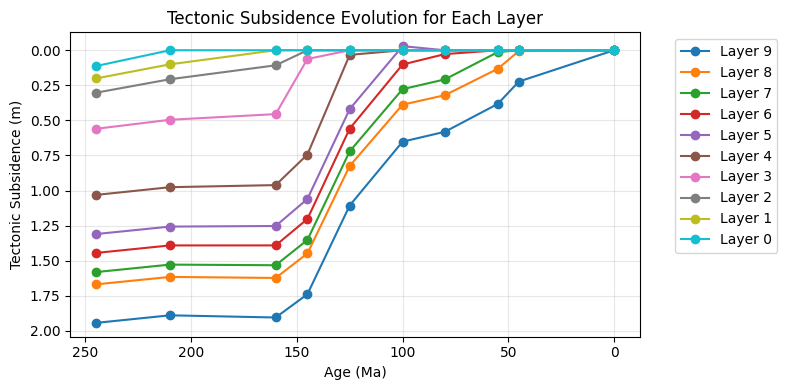

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(8, 4))

tectonic_subsidence_results = pd.read_csv('tectonic_subsidence_results.csv', index_col=0)
numeric_results = tectonic_subsidence_results.select_dtypes(include=['number'])

ages = np.sort(numeric_results.columns.astype(float))

for layer_idx, layer_row in numeric_results.iterrows():
    layer_name = f"Layer {int(layer_idx)}" if not isinstance(layer_idx, str) else layer_idx
    plt.plot(ages, layer_row.values, 'o-', label=layer_name)

plt.gca().invert_xaxis()  # Geological convention - oldest on right
plt.gca().invert_yaxis()
plt.xlabel('Age (Ma)')
plt.ylabel('Tectonic Subsidence (m)')
plt.title('Tectonic Subsidence Evolution for Each Layer')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Step 4: Thermal conductivity of the basin-fill

In [136]:
def bulk_thermal_conductivity(tc_matrix, tc_inclusion, porosity):
  return tc_matrix*(1-porosity) + tc_inclusion*porosity

In [137]:
def bulk_thermal_conductivity_geomean(tc_matrix, tc_inclusion, porosity):
  return tc_inclusion**porosity * tc_matrix**(1-porosity)

In [138]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
  return surface_T + (-basal_HF*depth * tc_bulk**-1)

In [151]:
# Prepare age list - ensure sorted chronologically (oldest first)
age_list = sorted(work_layers['Age (Ma)'].unique())
porosity_df = pd.read_csv('porosity_results.csv', index_col=0)
print("Age list to process:", age_list)

# Constants (use uppercase naming convention)
WATER_DENSITY = 1000
MANTLE_DENSITY = 3300
TC_WATER = 0.60
DEFAULT_TC = 3.00

# Pre-compute lithology matches to avoid repeated lookups
lithology_tc_map = Database_Lithotypes.set_index('Lithology type')['Thermal conductivity at 20 oC'].to_dict()

# Initialize results DataFrame with same index as work_layers
thermal_conductivity_bulk_df = pd.DataFrame(index=work_layers.index)

for age in age_list:
    print(f'\nProcessing age: {age} Ma')

    thermal_conductivity_values = []

    for idx, row in work_layers.iterrows():
        lithology = row['Lithology_type']
        layer_name = row['Event_name']

        # Get paleobathymetry and eustatic data
        PWD = row['Paleobathymetry, m'] / 1000 if pd.notna(row['Paleobathymetry, m']) else 0
        eustatic = row['Sea level, m'] / 1000 if pd.notna(row['Sea level, m']) else 0

        # Get thermal conductivity with default fallback
        tc_matrix = lithology_tc_map.get(lithology, DEFAULT_TC)

        # Get porosity - ensure proper error handling if not found
        try:
            porosity = porosity_df.loc[
                (porosity_df['Lithology_type'] == lithology) &
                (porosity_df['Event_name'] == layer_name),
                str(age)
            ].iloc[0]
        except IndexError:
            print(f"Warning: No porosity data found for {lithology} - {layer_name} at {age} Ma")
            porosity = 0  # or some reasonable default

        # Calculate bulk thermal conductivity
        tc_bulk = bulk_thermal_conductivity_geomean(tc_matrix, TC_WATER, porosity)
        thermal_conductivity_values.append(tc_bulk)

    # Store results for this age
    thermal_conductivity_bulk_df[str(age)] = thermal_conductivity_values

Age list to process: [np.float64(0.0), np.float64(45.0), np.float64(55.0), np.float64(80.0), np.float64(100.0), np.float64(125.0), np.float64(145.0), np.float64(160.0), np.float64(210.0), np.float64(245.0)]

Processing age: 0.0 Ma

Processing age: 45.0 Ma

Processing age: 55.0 Ma

Processing age: 80.0 Ma

Processing age: 100.0 Ma

Processing age: 125.0 Ma

Processing age: 145.0 Ma

Processing age: 160.0 Ma

Processing age: 210.0 Ma

Processing age: 245.0 Ma


In [152]:
thermal_conductivity_bulk_df = save_to_csv(thermal_conductivity_bulk_df,
                                           work_layers,
                                           'thermal_conductivity_bulk_results_defult.csv')
thermal_conductivity_bulk_df

,Lithology_type,Event_name,245.0,210.0,160.0,145.0,125.0,100.0,80.0,55.0,45.0,0.0
0,Shale (typical),Layer 10_1,1.64000,1.64,1.640000,1.640000,1.640000,1.640000,1.640000,1.640000,1.640000,0.872328
1,Sandstone (typical),Layer 9_1,3.95000,3.95,3.950000,3.950000,3.950000,3.950000,3.950000,3.950000,1.882913,1.994409
2,Shale (typical),Layer 8_1,1.64000,1.64,1.640000,1.640000,1.640000,1.640000,1.640000,1.020541,1.103160,1.177359
3,Chalk (typical),Layer 7_1,2.90000,2.90,2.900000,2.900000,2.900000,2.900000,1.674341,2.255318,2.319100,2.388179
4,Sandstone (typical),Layer 6_1,3.95000,3.95,3.950000,3.950000,3.950000,2.065333,2.688993,2.871123,2.902146,2.939245
5,Limestone (ooid grainstone),Layer 5_1,3.00000,3.00,3.000000,3.000000,1.708956,1.720135,1.735164,1.740680,1.741695,1.742944
6,Dolomite (typical),Layer 4_1,4.20000,4.20,4.200000,2.273433,2.378129,2.913435,3.440436,3.581439,3.604716,3.632250
7,Sandstone (typical),Layer 3_1,3.95000,3.95,1.902653,2.124216,2.197687,2.596341,3.039290,3.170753,3.193180,3.220008
8,Anhydrite,Layer 2_1,6.30000,6.30,6.300000,6.300000,6.300000,6.300000,6.300000,6.300000,6.300000,6.300000
9,"Sandstone (quartzite, very quartz rich)",Layer 1_1,2.56562,3.02,3.236938,3.530737,3.629609,4.179834,4.825346,5.026309,5.061131,5.103009


## Step 5. Calculation of the geotherm with variable thermal conductivity (a constant heat flow from the mantle)



## Step 6. The radiogenic heat contribution: Eqn. [A58.10]

In [153]:
def linear_geotherm(G, y):
  return G*y

In [154]:
def linear_geotherm_2(T0, Qm, A, yc, depth, K):
  return T0 + ((-Qm + A*yc)/K)*depth - (A/(2*K)*depth**2)

### Ap.13: Effects of variable radiogenic heating and thermal conductivity on the geotherm in the basin-fill - CHECK

Main Function

In [155]:
import pandas as pd

# Constants
T0 = 15  # Surface temperature (°C)
QM_WITH_HEAT = 30e-3  # Heat flow with radiogenic heat (W/m²)
QM_WITHOUT_HEAT = 25e-3  # Heat flow without radiogenic heat (W/m²)
QM_LINEAR = -60e-3    # Heat flow for linear geotherm (W/m²)
DEFAULT_A = 2.5e-6    # Default radiogenic heat production (µW/m³)
DEFAULT_K = 3.0       # Default thermal conductivity (W/m·K)
YC = 30e3             # Crustal thickness for linear geotherm (m)

def initialize_results_dataframes(work_layers):
    """Initialize empty DataFrames for storing results."""
    return (
        pd.DataFrame(index=work_layers.index),  # T_with_rad_heat
        pd.DataFrame(index=work_layers.index),  # T_without_rad_heat
        pd.DataFrame(index=work_layers.index)   # T_linear_geotherm
    )

def create_lithology_maps(df_constast, Database_Lithotypes):
    """Create dictionaries for lithology property lookups."""
    return {
        'heat_prod': df_constast.set_index('Lithology_type')['Radiogenic Heat Production'].apply(lambda x: x * 1e1).to_dict(),
        'thermal_cond': Database_Lithotypes.set_index('Lithology type')['Thermal conductivity at 20 oC'].to_dict()
    }

def calculate_layer_temperature(T_top, Q, K, A, thickness, cumulative_depth):
    """Calculate temperature at bottom of a layer."""
    if K <= 0:
        return T_top
    term1 = ((Q + A * cumulative_depth) / K) * thickness
    term2 = (A / (2 * K)) * thickness**2
    return T_top + term1 - term2

def get_surface_temperature(age, SWIT_data):
    """Get surface temperature for given age from SWIT data."""
    return SWIT_data.loc[SWIT_data['Time'] == age, 'Paleolatitude'].values[0]

def store_results(results, temp_data, total_layers, age_str):
    """Store results for a specific age in the results DataFrames."""
    for result_type in ['with_rad', 'without_rad', 'linear']:
        if result_type in temp_data and temp_data[result_type]['values']:
            resized = np.zeros(total_layers)
            values = temp_data[result_type]['values']
            resized[len(resized) - len(values):] = values
            results[result_type][age_str] = resized

In [170]:
def radiogenic_heat_production(database, lithology, porosity_df, layer_name, age):
    """
    Calculate radiogenic heat production for a specific lithology.

    Args:
        database: Database_Lithotypes DataFrame
        lithology: Lithology type name
        porosity_df: DataFrame with porosity data
        layer_name: Name of the layer
        age: Age in Ma

    Returns:
        Radiogenic heat production (QrBulk) in µW/m³
    """
    try:
        # Find lithology match
        lithology_match = database[database['Lithology type'] == str(lithology)]
        if lithology_match.empty:
            print(f"Warning: No lithology match found for {lithology}")
            return DEFAULT_A

        # Get density and radioactive elements
        RoGrain = lithology_match['Density'].iloc[0]
        U, Th, K = lithology_match[["Uranium", "Thorium", "Potassium"]].iloc[0]

        # Get porosity for this layer and age
        porosity = porosity_df.loc[
            (porosity_df['Lithology_type'] == lithology) &
            (porosity_df['Event_name'] == layer_name),
            str(age)
        ].iloc[0]

        # Calculate radiogenic heat production
        QrBulk = 0.01 * RoGrain * (9.25 * U + 2.56 * Th + 3.49 * K) * (1 - porosity)

        return QrBulk

    except Exception as e:
        print(f"Error calculating radiogenic heat for {lithology}: {str(e)}")
        return DEFAULT_A

def process_age(current_age, work_layers, lithology_maps, SWIT_, porosity_df):
    """Process all layers for a specific age with dynamic T0 and A."""
    current_T0 = get_surface_temperature(current_age, SWIT_)

    T_rad_values, T_no_rad_values, T_linear_values = [], [], []
    T_cumulative_rad = T_cumulative_no_rad = current_T0
    cumulative_depth = 0

    sorted_layers = work_layers.sort_values('Depth bottom, m', ascending=False)

    for idx, row in sorted_layers.iterrows():
        layer_age = row['Age (Ma)']
        lithology = row['Lithology_type']
        layer_name = row['Event_name']
        thickness = row['Thickness, m']
        depth_bottom = row['Depth bottom, m']

        if layer_age > current_age:
            T_rad_values.append(0.0)
            T_no_rad_values.append(0.0)
            T_linear_values.append(0.0)
            continue

        # Calculate radiogenic heat production for this layer
        A = radiogenic_heat_production(
            Database_Lithotypes,
            lithology,
            porosity_df,
            layer_name,
            current_age
        )*1e-8

        K = lithology_maps['thermal_cond'].get(lithology, DEFAULT_K)
        cumulative_depth += thickness

        # Calculate temperatures
        T_rad = calculate_layer_temperature(T_cumulative_rad, QM_WITH_HEAT, K, A, thickness, cumulative_depth)
        T_no_rad = calculate_layer_temperature(T_cumulative_no_rad, QM_WITHOUT_HEAT, K, 0, thickness, 0)

        T_rad_values.append(T_rad)
        T_no_rad_values.append(T_no_rad)
        T_linear_values.append(linear_geotherm_2(current_T0, QM_LINEAR, 0, YC, depth_bottom * 1000, DEFAULT_K))

        T_cumulative_rad, T_cumulative_no_rad = T_rad, T_no_rad

    return T_rad_values, T_no_rad_values, T_linear_values

def main(valid_layers, df_constast, Database_Lithotypes, SWIT_, porosity):
    """Main function with dynamic T0 and A."""
    T_with_rad_heat, T_without_rad_heat, T_linear_geotherm = initialize_results_dataframes(valid_layers)
    lithology_maps = create_lithology_maps(df_constast, Database_Lithotypes)

    age_list = sorted(valid_layers['Age (Ma)'].unique(), reverse=True)
    print("Age list to process:", age_list)

    for age, age_reversed in zip(age_list, sorted(age_list, reverse=False)):
        print(f'\nProcessing age: {age} Ma')
        rad, no_rad, linear = process_age(
            age, valid_layers, lithology_maps,
            SWIT_, porosity_df
        )

        T_with_rad_heat[str(age_reversed)] = rad
        T_without_rad_heat[str(age_reversed)] = no_rad
        T_linear_geotherm[str(age_reversed)] = linear

    return T_with_rad_heat, T_without_rad_heat, T_linear_geotherm

# Usage:
paleo_results = process_paleolatitude_data(
    df=Database_SWIT_coordinates_,
    reference_latitude=90
)

results = main(
    valid_layers=valid_layers,
    df_constast=df_constast,
    Database_Lithotypes=Database_Lithotypes,
    SWIT_=paleo_results,
    porosity=porosity_df
)

Age list to process: [np.float64(245.0), np.float64(210.0), np.float64(160.0), np.float64(145.0), np.float64(125.0), np.float64(100.0), np.float64(80.0), np.float64(55.0), np.float64(45.0), np.float64(0.0)]

Processing age: 245.0 Ma

Processing age: 210.0 Ma

Processing age: 160.0 Ma

Processing age: 145.0 Ma

Processing age: 125.0 Ma

Processing age: 100.0 Ma

Processing age: 80.0 Ma

Processing age: 55.0 Ma

Processing age: 45.0 Ma

Processing age: 0.0 Ma


Visualization Function

In [171]:
def plot_temperature_profiles(t_with_rad, t_without_rad, t_linear, depths, SWIT_, age='0'):
    """
    Plot temperature-depth profiles for three different thermal models.

    Parameters:
        t_with_rad (DataFrame): Temperatures with radiogenic heat
        t_without_rad (DataFrame): Temperatures without radiogenic heat
        t_linear (DataFrame): Linear geotherm temperatures
        depths (Series): Depth values for each layer
        age (str): Age column to plot (default '0')
    """
    if age not in t_with_rad.columns:
        raise ValueError(f"Age {age} not found in temperature DataFrames")

    depths = depths[0:t_with_rad.shape[1]]
    if len(depths) != len(t_with_rad):
        raise ValueError("Depth and temperature arrays must be same length")

    y_values = [0] + (depths).tolist()  # Convert to km

    def prepare_profile(temp_df, age_col):
        """Helper to prepare temperature profile with surface temp"""
        current_age = float(0)
        current_T0 = get_surface_temperature(current_age, SWIT_)
        return [current_T0] + temp_df[age_col].tolist()

    linear_profile = prepare_profile(t_linear, age)
    no_rad_profile = prepare_profile(t_without_rad, age)
    with_rad_profile = prepare_profile(t_with_rad, age)


    plt.figure(figsize=(6, 8))

    plt.plot(no_rad_profile, y_values,
             label='Constant A (no radiogenic heat)',
             marker='o', markersize=5, color='green', linestyle='-')

    plt.plot(linear_profile, y_values,
             label='Linear Geotherm',
             marker='s', markersize=5, color='red', linestyle='--')

    plt.plot(with_rad_profile, y_values,
             label='Variable A & K (with radiogenic heat)',
             marker='^', markersize=5, color='blue', linestyle='-.')

    plt.xlabel('Temperature (°C)', fontsize=12, labelpad=10)
    plt.ylabel('Depth (km)', fontsize=12)
    plt.title(f'Temperature-Depth Profiles (Age = {age} Ma)', pad=20)

    # plt.xlim(0, 140)
    plt.ylim(0, 5)
    plt.gca().invert_yaxis()

    plt.grid(color='gray', linestyle=':', linewidth=0.5, alpha=0.7)
    plt.legend(loc='lower right', framealpha=1)

    plt.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.tick_params(axis='y', right=True)

    plt.tight_layout()
    plt.show()

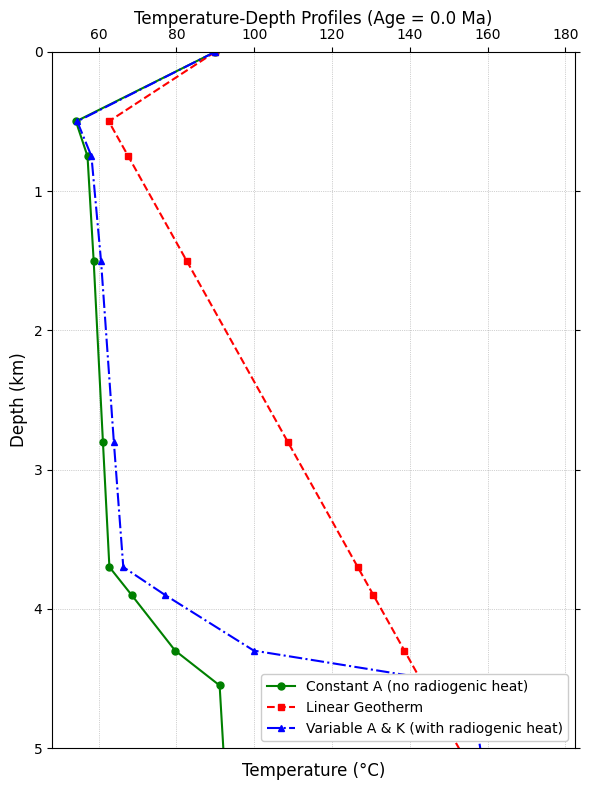

In [175]:
T_with_rad_heat, T_without_rad_heat, T_linear_geotherm = results

try:
    plot_temperature_profiles(
        t_with_rad=T_with_rad_heat,
        t_without_rad=T_without_rad_heat,
        t_linear=T_linear_geotherm[::-1],
        depths=work_layers["Depth bottom, m"],
        SWIT_=paleo_results,
        age=str(0.0)  # Can be changed to any age in your DataFrames
    )
except ValueError as e:
    print(f"Plotting error: {e}")

## Step 7. Calculation of the stretch factor

In [176]:
import warnings
from scipy import stats

warnings.filterwarnings("ignore")
warnings.filterwarnings("default")

In [177]:
from scipy.stats import linregress
from scipy.optimize import fsolve

In [180]:
tectonic_subsidence_df  # --> or output_df

,Lithology_type,Event_name,245.0,210.0,160.0,145.0,125.0,100.0,80.0,55.0,45.0,0.0
9,"Sandstone (quartzite, very quartz rich)",Layer 1_1,0.0,0.223155,0.382809,0.581290,0.651728,1.106749,1.739188,1.905025,1.889523,1.943434
8,Anhydrite,Layer 2_1,0.0,0.005951,0.132353,0.320451,0.388037,0.824704,1.448563,1.623150,1.615747,1.668867
7,Sandstone (typical),Layer 3_1,0.0,0.000000,0.013276,0.207824,0.277339,0.720596,1.352425,1.532462,1.528066,1.581405
6,Dolomite (typical),Layer 4_1,0.0,0.000000,0.000000,0.027653,0.101609,0.558705,1.202957,1.391090,1.391304,1.444889
5,Limestone (ooid grainstone),Layer 5_1,0.0,0.000000,0.000000,0.000000,-0.029055,0.419434,1.060110,1.252775,1.257004,1.310251
4,Sandstone (typical),Layer 6_1,0.0,0.000000,0.000000,0.000000,0.000000,0.032925,0.743506,0.961235,0.976196,1.031381
3,Chalk (typical),Layer 7_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.062314,0.455373,0.495555,0.560163
2,Shale (typical),Layer 8_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107445,0.206657,0.302829
1,Sandstone (typical),Layer 9_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100363,0.201142
0,Shale (typical),Layer 10_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112836


In [187]:
def calculate_stretch_factors(tectonic_subsidence, age_list, work_layers):
    from scipy.stats import linregress
    from scipy.optimize import fsolve
    import numpy as np
    import pandas as pd

    TAU = 50
    TM = 1330
    YL = 125
    ALPHA_V = 3.28e-5
    RHO_WATER = 1030
    RHO_MANTLE = 3300

    E0 = (4 * YL * RHO_MANTLE * ALPHA_V * TM) / \
         (np.pi**2 * (RHO_MANTLE - RHO_WATER)) * 1000

    stretch_factor_df = pd.DataFrame(index=['beta'])

    def stretch_factor(beta, slope):
        return E0 * (beta/np.pi) * np.sin(np.pi/beta) - slope

    numeric_ages = [age for age in age_list if str(age).replace('.', '').isdigit()]

    for age in numeric_ages:
        subsidence_values = tectonic_subsidence[age].dropna().values[::-1]
        non_zero_mask = subsidence_values != 0
        non_zero_values = subsidence_values[non_zero_mask]

        if len(non_zero_values) == 0:
            continue

        time_window = work_layers['Age (Ma)'].iloc[:len(non_zero_values)].values
        time = np.array(time_window)

        x = 1 - np.exp(-time/TAU)
        y = non_zero_values * 1000

        try:
            slope, _, _, _, _ = linregress(x, y)
            beta_initial_guess = 1.0
            beta = fsolve(stretch_factor, beta_initial_guess, args=(slope))[0]
            stretch_factor_df[str(age)] = [beta]
        except Exception as e:
            print(f"Error processing age {age}: {str(e)}")
            stretch_factor_df[str(age)] = np.nan

    return stretch_factor_df

numeric_columns = [col for col in tectonic_subsidence_df.columns
                  if str(col).replace('.', '').isdigit()]
stretch_factor_df = calculate_stretch_factors(
    tectonic_subsidence_df,
    numeric_columns,
    valid_layers
)

In [188]:
stretch_factor_df.to_csv('/content/Stretch_factor.csv', index=True)

In [189]:
stretch_factor_df

,210.0,160.0,145.0,125.0,100.0,80.0,55.0,45.0,0.0
beta,1.115973,1.133163,1.186753,1.212056,1.359731,1.669772,1.763427,1.773539,1.77465


In [191]:
for age in tectonic_subsidence_df.columns:
    try:
        float(age)
    except ValueError:
        continue

    col_list = list(tectonic_subsidence_df[age])
    thermal_subsidence = col_list[::-1]

    if all(item == 0 for item in thermal_subsidence):
        continue
    else:
        tau = 50
        non_zero_values = [value for value in thermal_subsidence if value != 0]

        # Get numeric columns only
        time_array = [float(col) for col in tectonic_subsidence_df.columns
                     if str(col).replace('.', '').isdigit()]
        time = np.array(time_array[0:len(non_zero_values)])

In [192]:
beta = stretch_factor_df["0.0"].iloc[0] # Значение, используемое для следующих расчетов
beta

np.float64(1.7746497851961676)

## Step 8. Calculation of paleotemperatures using the reference uniform stretching model



#### Heat Flow: Subsiding (right part)

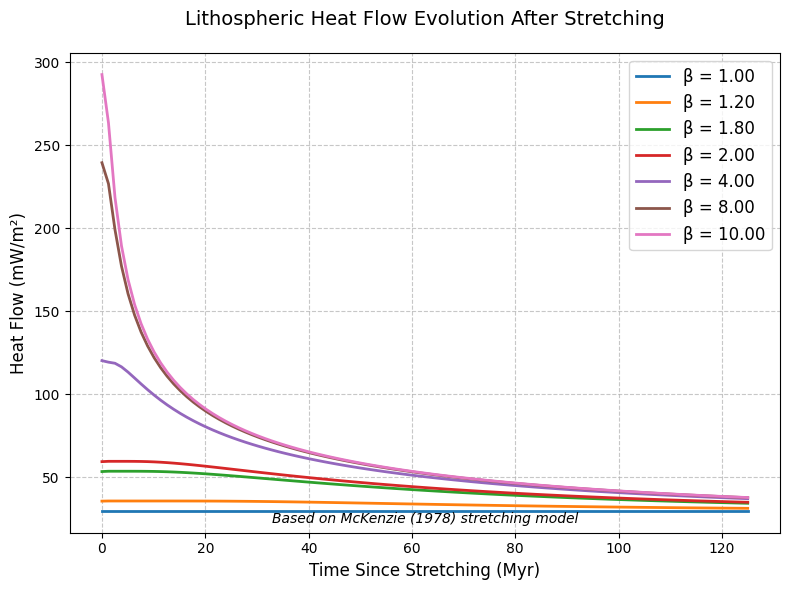

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union

def calculate_heat_flux(
    beta: Union[float, List[float]],
    time_myr: Union[float, np.ndarray],
    lithosphere_thickness_km: float = 125,
    thermal_time_constant_myr: float = 62.8,
    thermal_conductivity_wmk: float = 3.5,
    mantle_temperature_c: float = 1333,
    n_terms: int = 100
) -> np.ndarray:
    """
    Calculate heat flux for lithospheric stretching models using McKenzie's approach.

    Parameters:
        beta: Stretching factor(s) (float or list of floats)
        time_myr: Time since stretching event in million years (float or array)
        lithosphere_thickness_km: Thickness of lithosphere in km (default 125)
        thermal_time_constant_myr: Thermal time constant in Myr (default 62.8)
        thermal_conductivity_wmk: Thermal conductivity in W/m·K (default 3.5)
        mantle_temperature_c: Mantle temperature in °C (default 1333)
        n_terms: Number of terms in the series expansion (default 100)

    Returns:
        Array of heat flux values in mW/m²
    """

    beta_arr = np.atleast_1d(beta)
    time_arr = np.atleast_1d(time_myr)

    heat_flux = np.zeros((len(beta_arr), len(time_arr)))


    for i, b in enumerate(beta_arr):
        series_sum = 0.0
        for n in range(1, n_terms + 1):
            term = (b / (n * np.pi) * np.sin(n * np.pi / b) * np.exp(-n**2 * time_arr / thermal_time_constant_myr))
            series_sum += term

        # Calculate dimensionless temperature ratio
        T_over_Tm = 0.8 * (1 + 2 * series_sum)

        # Convert to heat flux (mW/m²)
        # heat_flux[i] = T_over_Tm * 60 * 697 *1e-3  # W/m² to mW/m², the factor 60*697*1e-3 from the original code
        heat_flux[i] = T_over_Tm * (thermal_conductivity_wmk * mantle_temperature_c /
                                   (lithosphere_thickness_km * 1000)) * 1e3  # W/m² to mW/m²

    return heat_flux.squeeze()  # Remove single-dimensional entries

# Parameters
beta_values = [1, 1.2, 1.8, 2, 4, 8, 10]
time_values = np.linspace(0, 125, 100)

# Calculate heat flux
flux = calculate_heat_flux(beta_values, time_values)

# Plotting
plt.figure(figsize=(8, 6))
for i, b in enumerate(np.atleast_1d(beta_values)):
    plt.plot(time_values, flux[i] if len(np.atleast_1d(beta_values)) > 1 else flux,
             label=f'β = {b:.2f}',
             linewidth=2)
plt.xlabel('Time Since Stretching (Myr)', fontsize=12)
plt.ylabel('Heat Flow (mW/m²)', fontsize=12)
plt.title('Lithospheric Heat Flow Evolution After Stretching', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.annotate('Based on McKenzie (1978) stretching model',
             xy=(0.5, 0.02), xycoords='axes fraction',
             ha='center', fontsize=10, style='italic')
plt.tight_layout()
plt.show()

#### Temperature = f (variable Heat Flow, Time)

In [226]:
import numpy as np
from typing import Union

def heat_flow_fundament_calculation(
    beta: float,
    t: float,
    Q_const: float = 63e-3,
    constant: bool = False,
    a: float = 125e3,
    k: float = 1e-6,
    lam: float = 3.5,
    T1: float = 1333,
    n_terms: int = 100
) -> float:
    """
    Calculate fundamental heat flow for lithospheric stretching models.

    Parameters:
    -----------
    beta : float
        Stretching factor (β > 1)
    t : float
        Time since stretching event (Myr)
    Q_const : float, optional
        Constant heat flow value (W/m²), default=63 mW/m²
    constant : bool, optional
        If True, returns Q_const, default=False
    a : float, optional
        Initial lithosphere thickness (m), default=125 km
    k : float, optional
        Thermal diffusivity (m²/s), default=1e-6
    lam : float, optional
        Thermal conductivity (W/mK), default=3.5
    T1 : float, optional
        Asthenosphere temperature (°C), default=1333
    n_terms : int, optional
        Number of terms in Fourier series, default=100

    Returns:
    --------
    float
        Heat flow in W/m²
    """

    if constant:
        return Q_const

    # Validate inputs
    if beta <= 0:
        raise ValueError("Stretching factor beta must be positive")
    if t < 0:
        raise ValueError("Time t must be non-negative")

    # Calculate lithospheric time constant (converted to Myr)
    tau = (a**2 / (k * np.pi**2)) / (60 * 60 * 24 * 365.25 * 1e6)  # Myr

    # Vectorized computation of Fourier series terms
    n = np.arange(1, n_terms + 1)
    Cn = (beta / (n * np.pi)) * np.sin(n * np.pi / beta) * np.exp(-n**2 * t / tau)
    F_sum = np.sum(Cn)

    # Calculate heat flow (convert to W/m² from W/m²)
    F = (lam * T1 / a) * (1 + 2 * F_sum)

    return F

Heat flow calcualtion for each age

Processing ages: [np.float64(245.0), np.float64(210.0), np.float64(160.0), np.float64(145.0), np.float64(125.0), np.float64(100.0), np.float64(80.0), np.float64(55.0), np.float64(45.0), np.float64(0.0)]


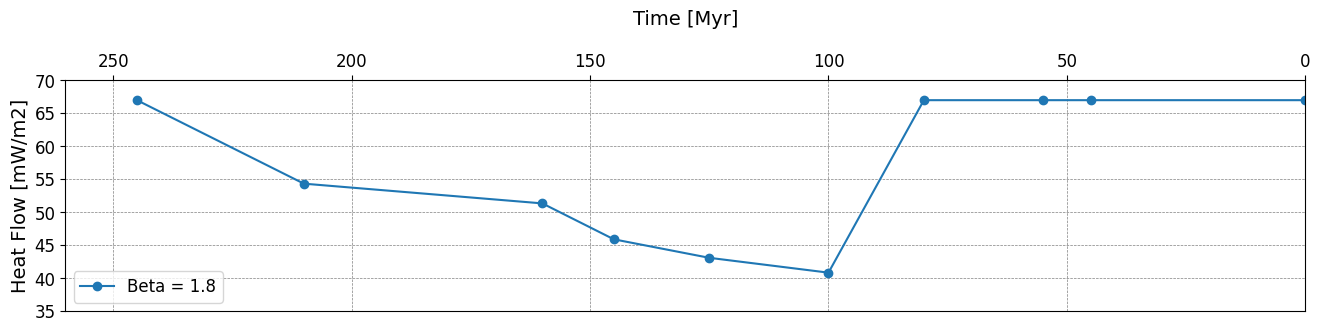

In [227]:
# Constants
T0 = 0  # Surface temperature (°C)
G = 10  # Geothermal gradient (°C/km)

# Prepare age list (sorted chronologically)
# age_list = sorted(work_layers_with_color['Age (Ma)'].unique())
print("Processing ages:", age_list)

# Pre-calculate heat flow values for all ages
beta = 1.8  # Stretching factor
Qm_array = []
for t in age_list:
    if t <= 125:
        Qm = heat_flow_fundament_calculation(beta, t, Q_const=53.7e-3, constant=False)
        Qm_array.append(Qm)
    else:
        Qm = heat_flow_fundament_calculation(beta, 0, Q_const=53.7e-3, constant=False)
        Qm_array.insert(0, Qm)

plt.figure(figsize=(16, 3))
plt.plot(age_list, [x * 10**3 for x in Qm_array[::-1]], label=f'Beta = {beta}', marker='o')

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)

ax = plt.gca()
ax.xaxis.set_label_position('top')  # Move x-axis label to top
ax.set_xlabel('Time [Myr]', labelpad=20, fontsize=14)
ax.set_ylabel('Heat Flow [mW/m2]', fontsize=14)

plt.xticks(fontsize=12)  # Increase x-axis tick label size
plt.yticks(fontsize=12)  # Increase y-axis tick label size

plt.legend(fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 260)
plt.ylim(35, 70)
plt.gca().invert_xaxis()
plt.savefig('HeatFlow.png', dpi=300, bbox_inches='tight')
plt.show()
# plt.ylim(0, 140)

In [203]:
# valid_layers = work_layers_copy[
#     work_layers_copy['Lithology_type'].notna() &
#     (work_layers_copy['Lithology_type'].astype(str).str.lower() != "nan")].copy() # Layers Selection with out fundament (=last layer)

decompaction_df = pd.read_csv('decompaction_corrected_results.csv', index_col=0)

# Create a dictionary for faster lithology property lookups
lithology_heat_prod = df_constast.set_index('Lithology_type')['Radiogenic Heat Production'].to_dict()

# Initialize results DataFrames with proper structure
T_with_rad_heat = pd.DataFrame(index=valid_layers.index)
T_without_rad_heat = pd.DataFrame(index=valid_layers.index)
T_linear_geotherm = pd.DataFrame(index=valid_layers.index)

# Get unique ages from the valid layers (oldest first)
age_list = sorted(valid_layers['Age (Ma)'].unique(), reverse=True)

for age_idx, age in enumerate(age_list):
    print(f"\nProcessing age {age_idx}: {age} Ma")

    # Get current heat flow value (using proper indexing)
    Qm = Qm_array[age_idx]

    # Initialize temperature and depth trackers
    cumulative_depth = 0
    cumulative_depth = T0
    T_cumulative_rad = T0  # Surface temperature
    T_cumulative_no_rad = T0

    T_rad_values = []
    T_no_rad_values = []
    T_linear_values = []

    for layer_idx, layer in valid_layers.iterrows():
        lithology = layer['Lithology_type']
        layer_name = layer['Event_name']

        # Get layer properties
        try:
            A = lithology_heat_prod[lithology]
            K = thermal_conductivity_bulk_df.at[layer_idx, str(age)]
            thickness = decompaction_df.at[layer_idx, str(age)] * 1000  # Convert km to m
            depth = decompaction_corrected_df.at[layer_idx, str(age)] * 1000  # Convert km to m
        except (IndexError, KeyError) as e:
            print(f"Warning: Missing data for {lithology} in {layer_name} at {age} Ma")
            continue

        # 1. Calculate temperature with radiogenic heat
        if K <= 0:
            # Handle zero/negative conductivity (use previous temperature)
            T_rad = T_cumulative_rad
        else:
            term1 = ((Qm + A * cumulative_depth) / K) * thickness
            term2 = (A / (2 * K)) * thickness**2
            T_rad = T_cumulative_rad + term1 - term2

        T_rad_values.append(T_rad)
        T_cumulative_rad = T_rad  # Update cumulative temperature

        # 2. Calculate temperature without radiogenic heat
        if K <= 0:
            T_no_rad = T_cumulative_no_rad
        else:
            term1 = (Qm / K) * thickness
            T_no_rad = T_cumulative_no_rad + term1

        T_no_rad_values.append(T_no_rad)
        T_cumulative_no_rad = T_no_rad  # Update cumulative temperature

        # 3. Calculate linear geotherm (in °C)
        T_linear = linear_geotherm(G, depth/1000)  # Assuming depth is converted back to km
        T_linear_values.append(T_linear)

        # Update cumulative depth for next layer
        cumulative_depth += thickness

    # Store results for this age
    T_with_rad_heat[str(age)] = T_rad_values
    T_without_rad_heat[str(age)] = T_no_rad_values
    T_linear_geotherm[str(age)] = T_linear_values


Processing age 0: 245.0 Ma

Processing age 1: 210.0 Ma

Processing age 2: 160.0 Ma

Processing age 3: 145.0 Ma

Processing age 4: 125.0 Ma

Processing age 5: 100.0 Ma

Processing age 6: 80.0 Ma

Processing age 7: 55.0 Ma

Processing age 8: 45.0 Ma

Processing age 9: 0.0 Ma


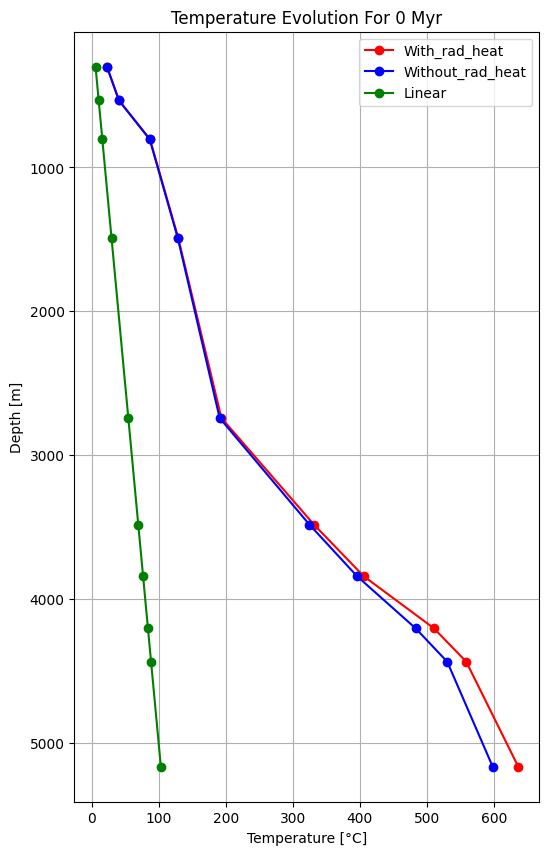

In [204]:
# Plot heat flow curve
plt.figure(figsize=(6, 10))

x_values = decompaction_corrected_df[str(0.0)] * 1000  # Convert km to m

plt.plot(T_with_rad_heat[str(0.0)], x_values, 'r-o', label=f'With_rad_heat')
plt.plot(T_without_rad_heat[str(0.0)], x_values, 'b-o', label=f'Without_rad_heat')
plt.plot(T_linear_geotherm[str(0.0)], x_values, 'g-o', label=f'Linear')
# plt.ylim(0, 5500)
plt.gca().invert_yaxis()
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [m]')
plt.title('Temperature Evolution For 0 Myr')
plt.grid(True)
plt.legend()
plt.show()

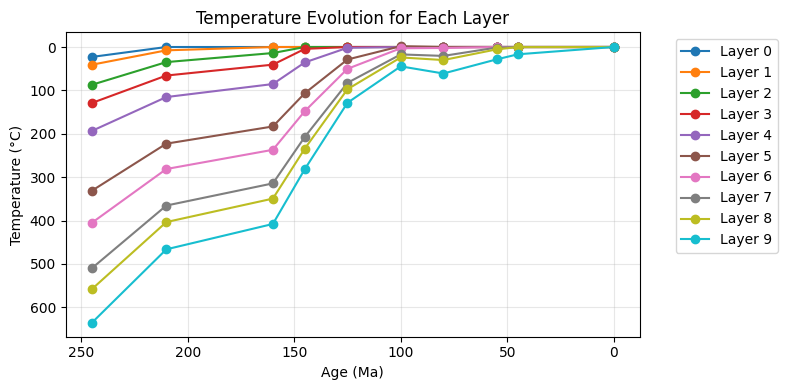

In [206]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))

ages = np.sort(pd.to_numeric(T_with_rad_heat.columns, errors='coerce'))

for layer_idx, layer_row in T_with_rad_heat.iterrows():
    layer_name = f"Layer {layer_idx}" if not isinstance(layer_idx, str) else layer_idx
    plt.plot(ages, layer_row.values, 'o-', label=layer_name)

plt.gca().invert_xaxis()  # Geological convention - oldest on right
plt.gca().invert_yaxis()
plt.xlabel('Age (Ma)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Evolution for Each Layer')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

###Sekiguchi–Waples Model = f(T, TCm)

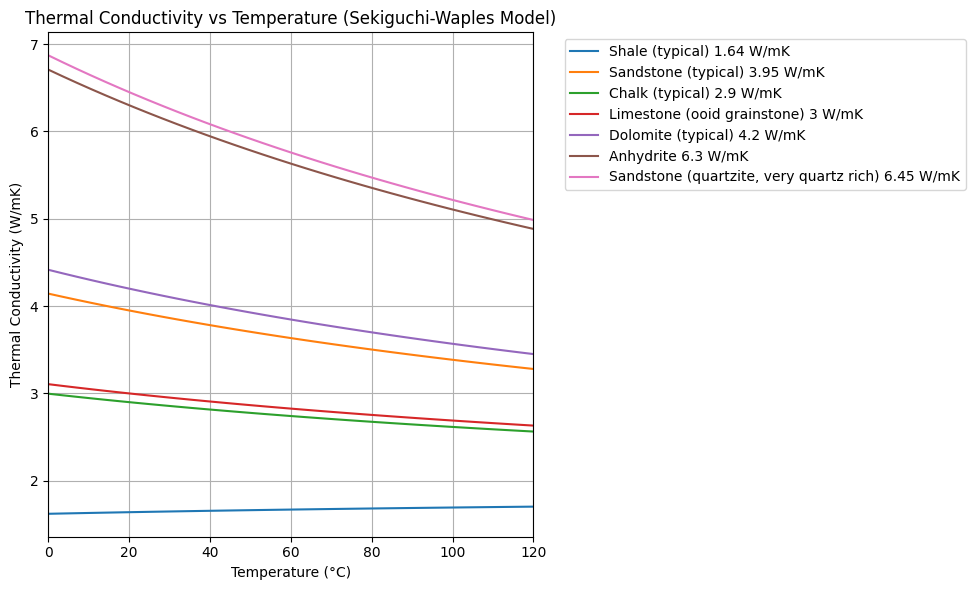

In [207]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Dict

def sekiguchi_waples(
    temperature_k: Union[float, np.ndarray],
    lambda_m: float,
    correction: bool = True
) -> Union[float, np.ndarray]:
    """Calculate thermal conductivity using Sekiguchi-Waples model.

    Args:
        temperature_k: Temperature in Kelvin
        lambda_m: Matrix thermal conductivity at 20°C (W/mK)
        correction: Whether to apply correction factor

    Returns:
        Thermal conductivity (W/mK)
    """
    if correction:
        return 358 * (1.0227 * lambda_m - 1.882) * (temperature_k**(-1) - 0.00068) + 1.84
    return 358 * lambda_m * temperature_k**(-1)

def plot_thermal_conductivity(
    df: pd.DataFrame,
    lithology_tc_map: Dict[str, float],
    default_tc: float = 2.5,
    max_temperature: float = 120
) -> None:
    """Plot thermal conductivity vs temperature for different lithologies.

    Args:
        df: DataFrame containing lithology data
        lithology_tc_map: Dictionary mapping lithology types to thermal conductivity values
        default_tc: Default thermal conductivity value for missing lithologies
        max_temperature: Maximum temperature to display (°C)
    """
    # Get unique lithologies and their TC values
    lithologies = df['Lithology_type'].unique()

    fig, ax = plt.subplots(figsize=(10, 6))

    for lithology in lithologies:
        # Get thermal conductivity value from the mapping, use default if not found
        tc_matrix = lithology_tc_map.get(lithology, default_tc)

        temperature_range = np.linspace(0, 350, 100)
        lambda_i_values = [
            sekiguchi_waples(T+273.15, tc_matrix, correction=True)
            for T in temperature_range
        ]

        ax.plot(
            temperature_range,
            lambda_i_values,
            label=f'{lithology} {tc_matrix} W/mK'
        )

    ax.set(
        xlabel='Temperature (°C)',
        ylabel='Thermal Conductivity (W/mK)',
        title='Thermal Conductivity vs Temperature (Sekiguchi-Waples Model)',
        xlim=(0, max_temperature)
    )
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


LITHOLOGY_TC_MAP = Database_Lithotypes.set_index('Lithology type')['Thermal conductivity at 20 oC'].to_dict()

plot_thermal_conductivity(
    df=work_layers,
    lithology_tc_map=LITHOLOGY_TC_MAP,
    default_tc=2.5,
    max_temperature=120
)

In [223]:
def calculate_thermal_models(work_layers_copy, df_constast, Database_Lithotypes, porosity_df,
                           decompaction_df, decompaction_corrected_df, SWIT_, beta=1.8, Q_const=30e-3):
    """
    Calculate thermal models (with/without radiogenic heat) and linear geotherms for geological layers.
    Now includes dynamic surface temperature (T0) and radiogenic heat production calculations.
    """
    # Constants
    G = 5  # Geothermal gradient (°C/km)
    TC_WATER = 0.60  # Thermal conductivity of water (W/m/K)

    # Filter valid layers with lithology information
    valid_layers = work_layers_copy[
        (work_layers_copy['Lithology_type'].notna()) &
        (work_layers_copy['Lithology_type'].astype(str).str.lower() != "nan")].copy()

    # Create thermal conductivity dictionary
    try:
        lithology_tc_map = Database_Lithotypes.set_index('Lithology type')['Thermal conductivity at 20 oC'].to_dict()
    except KeyError as e:
        raise ValueError(f"Missing required column in input data: {str(e)}")

    # Get unique ages (sorted oldest first)
    age_list = sorted(valid_layers['Age (Ma)'].unique())

    # Initialize results DataFrames
    results = {
        'with_rad': pd.DataFrame(index=valid_layers.index),
        'without_rad': pd.DataFrame(index=valid_layers.index),
        'linear': pd.DataFrame(index=valid_layers.index)  # Changed from 'linear'
    }

    # Calculate heat flow array
    # Qm = heat_flow_fundament_calculation(beta, age_list, Q_const, constant=False)

    Qm = calculate_heat_flux(beta, age_list)
    print('HF', Qm)
    plt.plot(age_list, Qm)
    # Qm_array = calculate_heat_flow_array(age_list, beta, Q_const)

    # Process each time period
    for age_idx, age in enumerate(age_list):
        # Get dynamic surface temperature for this age
        T0 = get_surface_temperature(age, SWIT_)
        print(f"\nProcessing age {age} Ma (index {age_idx}) with surface temp {T0:.1f}°C")

        # Initialize temperature calculations
        temp_data = {
            'with_rad': {'sum1': [], 'sum2': [], 'values': [], 'cumulative': T0},
            'without_rad': {'sum1': [], 'values': [], 'cumulative': T0},
            'linear': {'values': []}
        }

        cumulative_depth = 0
        K_list = []

        # Process each layer
        for layer_idx, layer in valid_layers.iterrows():
            lithology = layer['Lithology_type']
            layer_name = layer['Event_name']

            try:
                # Get dynamic radiogenic heat production for this layer
                A = radiogenic_heat_production(
                    Database_Lithotypes,
                    lithology,
                    porosity_df,
                    layer_name,
                    age
                )

                tc_matrix = lithology_tc_map.get(lithology, 0)  # Default to 0 if not found

                try:
                    phi0 = porosity_df.loc[
                        (porosity_df['Lithology_type'] == lithology) &
                        (porosity_df['Event_name'] == layer_name),
                        str(age)
                    ].iloc[0]
                    thickness = decompaction_df.at[layer_idx, str(age)] * 1000
                    depth = decompaction_corrected_df.at[layer_idx, str(age)] * 1000
                except (KeyError, IndexError) as e:
                    print(f"Warning: Missing property data for {lithology} in {layer_name} at {age} Ma")
                    continue

                # Calculate temperature-corrected thermal conductivity
                current_temp = temp_data['with_rad']['cumulative']
                T_sg = current_temp if layer_idx > 0 else T0
                T_sg = max(T_sg, 1e-3)  # Avoid division by zero

                try:
                    K_mtrx_corrected = sekiguchi_waples(T_sg + 273.15, tc_matrix, correction=True)
                    K = bulk_thermal_conductivity_geomean(K_mtrx_corrected, TC_WATER, phi0)
                    K_list.append(K)
                except Exception as e:
                    print(f"Warning: Thermal conductivity calculation failed for {lithology}: {str(e)}")
                    K = 0



                # Update cumulative depth
                cumulative_depth += thickness
                # Qm = Qm_array[age_idx]
                current_Qm = Qm_array[age_idx]
                print(lithology, K, A, current_Qm)

                # print(lithology, layer_name, T0, A, T_sg, K)

                # Calculate temperatures
                # With radiogenic heat
                if K > 0:
                    term1 = ((current_Qm + A * cumulative_depth) / K) * thickness
                    term2 = (A / (2 * K)) * thickness**2
                    temp_data['with_rad']['sum1'].append(term1)
                    temp_data['with_rad']['sum2'].append(term2)
                    T_rad = sum(temp_data['with_rad']['sum1']) - sum(temp_data['with_rad']['sum2'])
                else:
                    T_rad = temp_data['with_rad']['cumulative']

                temp_data['with_rad']['values'].append(T_rad)
                temp_data['with_rad']['cumulative'] = T_rad

                # Without radiogenic heat
                if K > 0:
                    term = (current_Qm / K) * thickness
                    temp_data['without_rad']['sum1'].append(term)
                    T_no_rad = sum(temp_data['without_rad']['sum1'])
                else:
                    T_no_rad = temp_data['without_rad']['cumulative']

                temp_data['without_rad']['values'].append(T_no_rad)
                temp_data['without_rad']['cumulative'] = T_no_rad

                # Linear geotherm
                temp_data['linear']['values'].append(linear_geotherm(G, depth/1000))

            except Exception as e:
                print(f"Error processing {lithology} in {layer_name}: {str(e)}")
                continue

        # Store results for this age
        store_results(results, temp_data, valid_layers.shape[0], str(age))

    return results['with_rad'], results['without_rad'], results['linear']

def radiogenic_heat_production(database, lithology, porosity_df, layer_name, age):
    """
    Calculate radiogenic heat production for a specific lithology.

    Args:
        database: Database_Lithotypes DataFrame
        lithology: Lithology type name
        porosity_df: DataFrame with porosity data
        layer_name: Name of the layer
        age: Age in Ma

    Returns:
        Radiogenic heat production (QrBulk) in µW/m³
    """
    try:
        # Find lithology match
        lithology_match = database[database['Lithology type'] == str(lithology)]
        if lithology_match.empty:
            print(f"Warning: No lithology match found for {lithology}")
            return 0  # Return 0 instead of DEFAULT_A to match original behavior

        # Get density and radioactive elements
        RoGrain = lithology_match['Density'].iloc[0]
        U, Th, K = lithology_match[["Uranium", "Thorium", "Potassium"]].iloc[0]

        # Get porosity for this layer and age
        porosity = porosity_df.loc[
            (porosity_df['Lithology_type'] == lithology) &
            (porosity_df['Event_name'] == layer_name),
            str(age)
        ].iloc[0]

        # Calculate radiogenic heat production (µW/m³)
        QrBulk = 0.01 * RoGrain * (9.25 * U + 2.56 * Th + 3.49 * K) * (1 - porosity) * 1e-8

        return QrBulk

    except Exception as e:
        print(f"Error calculating radiogenic heat for {lithology}: {str(e)}")
        return 0  # Return 0 instead of DEFAULT_A to match original behavior

In [224]:
T_with_rad

,0.0,45.0,55.0,80.0,100.0,125.0,145.0,160.0,210.0,245.0
0,23.157890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,41.866974,9.321130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,98.639654,46.190645,18.767444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,152.692688,90.018484,55.967180,6.153347,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,258.625103,177.503433,132.170980,55.537917,1.639833,0.000000,0.000000,0.000000,0.000000,0.0
5,456.558823,354.791157,295.268252,174.040096,27.737912,-1.977388,0.000000,0.000000,0.000000,0.0
6,626.396103,502.791921,428.926109,267.466538,50.529885,2.952739,1.511121,0.000000,0.000000,0.0
7,985.902411,815.309234,709.824993,455.868862,95.839248,18.534509,14.160076,1.015050,0.000000,0.0
8,1171.882237,976.616530,854.732820,552.425528,114.846098,26.079293,20.715754,3.987745,0.161919,0.0
9,1585.876781,1335.525144,1176.935800,767.145100,165.671449,51.175710,44.342231,21.752025,13.274968,0.0


HF [53.55458809 45.96888216 43.71487418 39.2495548  36.7045342  34.46123772
 33.20699036 32.495916   31.04857915 30.54040827]

Processing age 0.0 Ma (index 0) with surface temp 90.0°C
Shale (typical) 0.8817410704389901 7.4731555349919575e-06 0.0669432351083499
Sandstone (typical) 1.9852679950293308 4.424697484860396e-06 0.0669432351083499
Shale (typical) 1.1855922710219704 1.346114767485476e-05 0.0669432351083499
Chalk (typical) 2.1846079528840265 5.176739953959077e-06 0.0669432351083499
Sandstone (typical) 2.414762718114008 5.853234436420568e-06 0.0669432351083499
Limestone (ooid grainstone) 1.4824620882996296 2.270830729372817e-06 0.0669432351083499
Dolomite (typical) 2.1945334724967824 2.6674842669851906e-06 0.0669432351083499
Sandstone (typical) 1.8903348025799975 6.1892975412371206e-06 0.0669432351083499
Anhydrite 2.0265490673315454 9.174330000000001e-07 0.0669432351083499
Sandstone (quartzite, very quartz rich) 1.6638333896964883 2.7175061961454566e-06 0.0669432351083499

Process

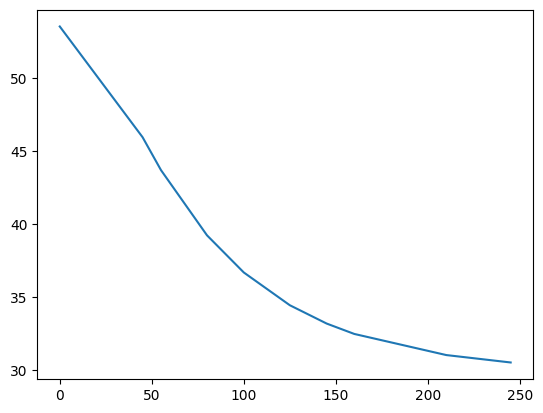

In [225]:
T_with_rad, T_without_rad, T_linear = calculate_thermal_models(
    valid_layers,
    df_constast,
    Database_Lithotypes,
    porosity_df,
    decompaction_df,
    decompaction_corrected_df,
    SWIT_=paleo_results,
    beta=1.8
)

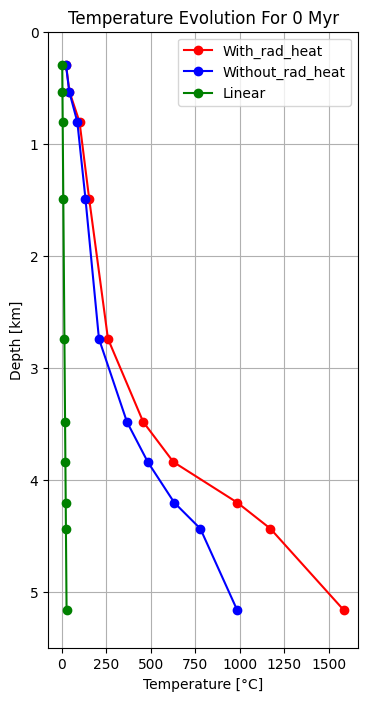

In [219]:
# Plot heat flow curve
plt.figure(figsize=(4, 8))

x_values = decompaction_df[str(0.0)]

plt.plot(T_with_rad[str(0.0)], x_values, 'r-o', label=f'With_rad_heat')
plt.plot(T_without_rad[str(0.0)], x_values, 'b-o', label=f'Without_rad_heat')
plt.plot(T_linear[str(0.0)], x_values, 'g-o', label=f'Linear')
plt.ylim(0, 5.5)
plt.gca().invert_yaxis()
plt.xlabel('Temperature [°C]')
plt.ylabel('Depth [km]')
plt.title('Temperature Evolution For 0 Myr')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 4))

ages = np.sort(pd.to_numeric(T_with_rad.columns, errors='coerce'))

for layer_idx, layer_row in T_with_rad.iterrows():
    layer_name = f"Layer {layer_idx}" if not isinstance(layer_idx, str) else layer_idx
    plt.plot(ages, layer_row.values, 'o-', label=layer_name)

plt.gca().invert_xaxis()  # Geological convention - oldest on right
plt.gca().invert_yaxis()
plt.xlabel('Age (Ma)')
plt.ylabel('Paleotemperature (°C)')
plt.title('Temperature Evolution for Each Layer')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### Present day heat flow (a) and temperature (b)

In [ ]:
# Create figure with three subplots (temperature, heat flow, and geological column)
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])  # Adjust ratios as needed

ax1 = fig.add_subplot(gs[0])  # Temperature vs Depth
ax2 = fig.add_subplot(gs[1])  # Heat Flow vs Depth
ax_geo = fig.add_subplot(gs[2])  # Geological column

# --- Plot 1: Temperature vs Depth ---
x_values = decompaction_df[str(0.0)] * 1000   # Depth values in meters

ax1.plot(T_with_rad[str(0.0)], x_values, 'r-o', markersize=5, label='With radiogenic heat')
ax1.plot(T_without_rad[str(0.0)], x_values, 'b-o', markersize=5, label='Without radiogenic heat')
ax1.plot(T_linear[str(0.0)], x_values, 'g-o', markersize=5, label='Linear')

ax1.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Temperature [°C]', fontsize=12, labelpad=10)
ax1.set_ylabel('Depth [m]', fontsize=12, labelpad=10)

ax1.set_xlim(0, 500)
ax1.invert_yaxis()  # Surface at top
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=10)


# --- Plot 2: Heat Flow vs Depth ---
ax2.plot([x * 1e3 for x in Qm_array],
         x_values,
         label=f'Beta = {beta}', marker='o', color='purple')

ax2.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Heat Flow [mW/m²]', fontsize=12, labelpad=10)
ax2.set_ylabel('Depth [m]', labelpad=10, fontsize=12)

ax2.set_xlim(40, 70)
ax2.invert_yaxis()  # Surface at top
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=10)

# --- Geological Column ---
ax_geo.set_xlim(0, 1)
ax_geo.set_xticks([])
ax_geo.set_xticklabels([])
ax_geo.xaxis.set_label_position('top')
ax_geo.set_xlabel('Geological Column', fontsize=12, labelpad=25)
ax_geo.grid(False)

# Get unique lithologies and their colors
lithologies = valid_layers['Lithology_type'].unique()
litho_colors = {lith: plt.cm.tab20(i/len(lithologies)) for i, lith in enumerate(lithologies)}

# Use present-day (0 Myr) depths only
present_col = str('0.0')

# Plot connecting line for surface layer
for ax in [ax1, ax2]:
    ax.plot([0, 0], [0, 0], 'k--', lw=0.5, alpha=0.5)  # Surface at 0m
    ax.plot([0, 0.87], [0, 0], 'k--', lw=0.5, alpha=0.5)

# Plot the geological layers using only present-day depths
prev_depth = 0  # Start from surface (0m)
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    try:
        current_depth = decompaction_df.loc[layer_idx, present_col] * 1000
        if np.isnan(current_depth):
            continue

        lithology = valid_layers.loc[layer_idx, 'Lithology_type']
        color = litho_colors[lithology]

        # Draw connecting lines from both plots to geological column
        for ax in [ax1, ax2]:
            ax.plot([0, 0], [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)
            ax.plot([0, 2.4], [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)

        # Draw layer in geological column
        ax_geo.fill_betweenx([prev_depth, current_depth], 0, 1,
                           color=color, alpha=0.6)
        ax_geo.text(0.5, (prev_depth + current_depth)/2,
                   lithology, ha='center', va='center', fontsize=9)

        prev_depth = current_depth

    except KeyError:
        continue

# Remove y-axis from geological column and ensure surface is at top
ax_geo.yaxis.set_visible(False)
ax_geo.invert_yaxis()  # This ensures surface stays at top

# Adjust layout and save
plt.tight_layout()
plt.savefig('Temerature&HeatFlow_with_Geology.png', dpi=300, bbox_inches='tight')
plt.show()

#### Tempreture during burial history and SWI temperature trend with radioctivity

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import PolyCollection
from scipy.interpolate import interp1d

plt.figure(figsize=(8, 10))  # Increased width to accommodate geological column

# Data preparation
ages = np.array(np.sort(pd.to_numeric(T_with_rad.columns, errors='coerce')))
temp_cmap = plt.cm.rainbow
norm = plt.Normalize(vmin=T_with_rad.values.min(), vmax=T_with_rad.values.max())

# Create main plot area (leave space on right for geological column)
ax_main = plt.axes([0.1, 0.15, 0.75, 0.75])  # [left, bottom, width, height]

# --- 1. Create interpolated temperature fields ---
def create_interpolated_grid(layer_idx, n_interp=100):
    """Returns interpolated ages, depths and temps for smoother plotting"""
    depth_values = np.array([decompaction_corrected_df.loc[layer_idx, str(age)]
                           if str(age) in decompaction_corrected_df.columns
                           else np.nan for age in ages]) * 1000
    temp_values = T_with_rad.loc[layer_idx].values

    # Filter valid points
    valid_mask = ~np.isnan(depth_values)
    valid_ages = ages[valid_mask]
    valid_depths = depth_values[valid_mask]
    valid_temps = temp_values[valid_mask]

    if len(valid_ages) < 2:
        return None, None, None

    # Create interpolation functions
    depth_interp = interp1d(valid_ages, valid_depths, kind='linear', fill_value="interpolate")
    temp_interp = interp1d(valid_ages, valid_temps, kind='linear', fill_value="interpolate")

    # New finer grid
    interp_ages = np.linspace(ages.min(), ages.max(), n_interp)
    interp_depths = depth_interp(interp_ages)
    interp_temps = temp_interp(interp_ages)

    return interp_ages, interp_depths, interp_temps

# --- 2. Plot with smooth temperature coloring ---

# First handle the surface layer (0-0.5m)
surface_depth = 0.5 * 1000  # Your surface layer thickness

# Get temperature data for surface (use first layer's temperature)
surface_temp = T_with_rad.iloc[0].values
surface_temp_func = interp1d(ages, surface_temp, kind='linear', fill_value="extrapolate")

# Get data for first subsurface layer (0.5m+)
ages1, depths1, temps1 = create_interpolated_grid(T_with_rad.index[0])

if ages1 is not None:
    polygons = []
    color_values = []

    # Create matching time points for surface and subsurface
    interp_ages = np.linspace(ages.min(), ages.max(), len(ages1))

    # Get interpolated temperatures for surface at these time points
    surface_temps_interp = surface_temp_func(interp_ages)

    for j in range(len(interp_ages)-1):
        # Calculate average temperature between surface and first subsurface layer
        avg_temp = (surface_temps_interp[j] + surface_temps_interp[j+1] +
                   temps1[j] + temps1[j+1]) / 4

        poly_verts = [
            (interp_ages[j], 0),  # Surface at 0m
            (interp_ages[j+1], 0),  # Surface at 0m
            (interp_ages[j+1], depths1[j+1]),  # First subsurface layer
            (interp_ages[j], depths1[j])  # First subsurface layer
        ]
        polygons.append(poly_verts)
        color_values.append(avg_temp)

    # Add the surface layer polygons
    if polygons:  # Only add if we have valid polygons
        poly_collection = PolyCollection(
            polygons,
            array=np.array(color_values),
            cmap=temp_cmap,
            norm=norm,
            alpha=0.6,
            edgecolor='none'
        )
        ax_main.add_collection(poly_collection)

# Then plot the remaining layers as before
for i in range(len(T_with_rad) - 1):
    ages1, depths1, temps1 = create_interpolated_grid(T_with_rad.index[i])
    ages2, depths2, temps2 = create_interpolated_grid(T_with_rad.index[i+1])

    if ages1 is None or ages2 is None:
        continue

    polygons = []
    color_values = []

    for j in range(len(ages1)-1):
        avg_temp = (temps1[j] + temps1[j+1] + temps2[j] + temps2[j+1]) / 4
        poly_verts = [
            (ages1[j], depths1[j]),
            (ages1[j+1], depths1[j+1]),
            (ages2[j+1], depths2[j+1]),
            (ages2[j], depths2[j])
        ]
        polygons.append(poly_verts)
        color_values.append(avg_temp)

    poly_collection = PolyCollection(
        polygons,
        array=np.array(color_values),
        cmap=temp_cmap,
        norm=norm,
        alpha=0.6,
        edgecolor='none'
    )
    ax_main.add_collection(poly_collection)

# --- 3. Plot original scatter points ---
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    depth_values = np.array([decompaction_corrected_df.loc[layer_idx, str(age)]
                           if str(age) in decompaction_corrected_df.columns
                           else np.nan for age in ages]) * 1000
    sc = ax_main.scatter(ages, depth_values, c=layer_row.values, cmap=temp_cmap,
                       s=0, edgecolor='k', linewidth=0.5, zorder=3)

# --- 4. Create geological column ---
ax_geo = plt.axes([0.816, 0.15, 0.3, 0.75], sharey=ax_main)
ax_geo.set_xlim(0, 1)
ax_geo.set_xticks([])
ax_geo.set_xticklabels([])
ax_geo.xaxis.set_label_position('top')  # Move x-axis label to top
ax_geo.set_xlabel('Geological Column', fontsize=12, labelpad=25)  # Changed 'pad' to 'labelpad'
# ax_geo.set_title('Geological Column', fontsize=12, labelpad=10)
ax_geo.grid(False)

# Get unique lithologies and their colors
lithologies = valid_layers['Lithology_type'].unique()
litho_colors = {lith: plt.cm.tab20(i/len(lithologies)) for i, lith in enumerate(lithologies)}

# Find the column name closest to present day (age=0)
present_col = None
min_diff = float('inf')
for col in decompaction_corrected_df.columns :
    try:
        age = float(col)
        if abs(age) < min_diff:
            min_diff = abs(age)
            present_col = col
    except ValueError:
        continue

if present_col is None:
    present_col = decompaction_corrected_df.columns[-1]

# First draw the surface layer (0 to 0.5m)
# surface_lithology = valid_layers.iloc[0]['Lithology_type']  # Assuming first layer is surface
# print(surface_lithology)
# ax_geo.fill_betweenx([0, 0.5], 0, 1,
#                     color=litho_colors[surface_lithology],
#                     alpha=0.6)
# ax_geo.text(0.5, 0.25, surface_lithology,
#            ha='center', va='center', fontsize=9)

# Plot connecting line for surface layer
ax_main.plot([float(present_col), float(present_col)], [0.5, 0.5], 'k--', lw=0.5, alpha=0.5)
ax_main.plot([float(present_col), 0.87], [0.5, 0.5], 'k--', lw=0.5, alpha=0.5)

# Now plot the remaining layers
prev_depth = 0  # Start from the bottom of the surface layer
for i, (layer_idx, layer_row) in enumerate(T_with_rad.iterrows()):
    try:
        current_depth = decompaction_corrected_df.loc[layer_idx, present_col] * 1000
        if np.isnan(current_depth):
            continue

        lithology = valid_layers.loc[layer_idx, 'Lithology_type']
        color = litho_colors[lithology]

        # Draw connecting line from main plot to geological column
        ax_main.plot([float(present_col), float(present_col)],
                   [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)
        ax_main.plot([float(present_col), 0.87], [current_depth, current_depth], 'k--', lw=0.5, alpha=0.5)

        # Draw layer in geological column
        ax_geo.fill_betweenx([prev_depth, current_depth], 0, 1,
                           color=color, alpha=0.6)
        ax_geo.text(0.5, (prev_depth + current_depth)/2,
                   lithology, ha='center', va='center', fontsize=9)

        prev_depth = current_depth

    except KeyError:
        continue

# --- 5. Final adjustments ---
ax_main.invert_xaxis()
ax_main.invert_yaxis()
ax_main.xaxis.set_label_position('top')  # Move x-axis label to top
ax_main.set_xlabel('Geological Time [Ma]', fontsize=12, labelpad=10)  # Changed 'pad' to 'labelpad'
ax_main.set_ylabel('Depth [m]', fontsize=12)
ax_main.grid(True, alpha=0.3)
ax_main.tick_params(axis='both', which='major', labelsize=10, bottom=False, top=True, labelbottom=False, labeltop=True)

# Add horizontal colorbar below main plot
cax = plt.axes([0.1, 0.08, 0.75, 0.03])  # [left, bottom, width, height]
cbar = plt.colorbar(sc, cax=cax, orientation='horizontal')
cbar.set_label('Temperature (°C)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Remove y-axis from geological column
ax_geo.yaxis.set_visible(False)

plt.savefig('Tempreture_during_burial_history_with_Geology.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# Left part of heat flow

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.optimize import root_scalar
from scipy.special import erf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

# Physical constants
a = 125e3       # lithosphere thickness [m]
k = 3.5       # thermal conductivity [W/m/K]
T1 = 1333       # asthenosphere temperature [°C]
# kappa = 8.04e-7 # thermal diffusivity [m²/s]
kappa = 1e-6 # thermal diffusivity [m²/s]

SECONDS_PER_MYR = 1e6 * 365.25 * 24 * 3600  # seconds in 1 million years

class EnhancedThermalModel:
    def __init__(self, G_prime, n_eigenvalues=5, z_resolution=1000):
        self.G_prime = G_prime
        self.n_eigenvalues = n_eigenvalues
        self.z_resolution = z_resolution
        self.eigenvalues = None
        self.eigenfunctions = None
        self.dtheta_n = None
        self.coefficients = None
        self.z_points = np.linspace(0, 1, z_resolution)

    def diff_eq(self, z, y, K):
        theta, dtheta = y
        return [dtheta,
                -self.G_prime*(1-z)*dtheta - K*theta]

    def propagator_matrix(self, K):
        sol = solve_ivp(
            fun=lambda z, y: self.diff_eq(z, y, K),
            t_span=(0, 1),
            y0=[0, 1],
            method='RK45',
            dense_output=True
        )
        return sol.sol(1)[0]

    def find_eigenvalues(self):
        print(f"Finding {self.n_eigenvalues} eigenvalues...")
        self.eigenvalues = []

        def equation(K):
            return self.propagator_matrix(K)

        K_guesses = [(n+1)**2 * np.pi**2 + self.G_prime/2 for n in range(self.n_eigenvalues)]

        for i, guess in enumerate(tqdm(K_guesses)):
            try:
                res = root_scalar(
                    equation,
                    x0=guess,
                    method='newton',
                    fprime=lambda K: (equation(K+1e-6) - equation(K-1e-6))/2e-6,
                    rtol=1e-6
                )
                if res.converged:
                    self.eigenvalues.append(res.root)
            except Exception as e:
                print(f"Warning: Could not find eigenvalue {i}: {str(e)}")
                continue

        self.eigenvalues = sorted(self.eigenvalues)[:self.n_eigenvalues]
        return self.eigenvalues

    def compute_eigenfunctions(self):
        if self.eigenvalues is None:
            self.find_eigenvalues()

        self.eigenfunctions = []
        print("Computing eigenfunctions...")

        for K in tqdm(self.eigenvalues):
            sol = solve_ivp(
                fun=lambda z, y: self.diff_eq(z, y, K),
                t_span=(0, 1),
                y0=[0, 1],
                t_eval=self.z_points,
                method='RK45'
            )
            self.eigenfunctions.append(sol.y[0])

        return self.z_points, self.eigenfunctions

    def compute_derivatives(self):
        self.dtheta_n = []
        print("Computing derivatives...")

        for K in tqdm(self.eigenvalues):
            sol = solve_ivp(
                fun=lambda z, y: self.diff_eq(z, y, K),
                t_span=(0, 1),
                y0=[0, 1],
                t_eval=[1],
                method='RK45'
            )
            self.dtheta_n.append(sol.y[1][0])

        return self.dtheta_n

    def _compute_normalization(self, theta_n):
        integrand = lambda z: (np.exp((z-1)**2 * self.G_prime/2) *
                             np.interp(z, self.z_points, theta_n)**2)
        return quad(integrand, 0, 1, limit=200)[0]

    def _compute_coefficient(self, initial_condition, theta_n, norm):
        integrand = lambda z: (initial_condition(z) *
                              np.interp(z, self.z_points, theta_n) *
                              np.exp((z-1)**2 * self.G_prime/2))
        return quad(integrand, 0, 1, limit=200)[0] / norm

    def compute_coefficients(self, initial_condition):
        if self.eigenfunctions is None:
            self.compute_eigenfunctions()

        self.coefficients = []
        print("Computing expansion coefficients...")

        for theta_n in tqdm(self.eigenfunctions):
            try:
                norm = self._compute_normalization(theta_n)
                an = self._compute_coefficient(initial_condition, theta_n, norm)
                self.coefficients.append(an)
            except Exception as e:
                print(f"Warning: Coefficient calculation failed: {str(e)}")
                self.coefficients.append(0)

        return self.coefficients

    def thermal_flux(self, t_myr):
        if None in [self.eigenvalues, self.coefficients, self.dtheta_n]:
            raise ValueError("Model not fully initialized")

        t_sec = t_myr * SECONDS_PER_MYR

        steady_term = (2/np.pi) * erf(np.sqrt(self.G_prime/2))

        transient_term = 0
        for an, Kn, dtheta in zip(self.coefficients, self.eigenvalues, self.dtheta_n):
            exponent = -Kn * kappa * t_sec / a**2
            transient_term += an * np.exp(exponent) * dtheta

        return (k * T1 / a) * (steady_term + transient_term) * 1000

    def compute_flux_history(self, time_range):
        if self.dtheta_n is None:
            self.compute_derivatives()
        return np.array([self.thermal_flux(t) for t in tqdm(time_range)])

    def save_results(self, time_range, flux_values, prefix=""):
        flux_filename = f"{prefix}thermal_flux_Gprime_{self.G_prime:.1f}.dat"
        np.savetxt(flux_filename,
                  np.column_stack((time_range, flux_values)),
                  header=f"Thermal flux output (G'={self.G_prime:.1f})\nTime(Myr) Flux(mW/m2)",
                  fmt='%.4f')

        eigen_filename = f"{prefix}eigenvalues_Gprime_{self.G_prime:.1f}.dat"
        np.savetxt(eigenfilename,
                  np.column_stack((range(len(self.eigenvalues)),
                                 self.eigenvalues,
                                 self.coefficients)),
                  header="Eigenvalues and coefficients\nn K_n a_n",
                  fmt=['%d', '%.6f', '%.6f'])

        print(f"Results saved to {flux_filename} and {eigen_filename}")

def initial_condition(z):
    return np.sin(np.pi*z)

def plot_results(model, time_range, flux_values):
    plt.figure(figsize=(16, 12))
    plt.suptitle(f"Lithospheric Thermal Model (G' = {model.G_prime})", fontsize=16)
    gs = GridSpec(3, 2, width_ratios=[1.2, 1], height_ratios=[1, 1, 1])

    # 1. Eigenfunctions plot
    ax1 = plt.subplot(gs[0, 0])
    for i, (K, theta) in enumerate(zip(model.eigenvalues[:5], model.eigenfunctions[:5])):
        ax1.plot(model.z_points*a/1e3, theta, label=f'Mode {i+1} (K={K:.1f})')
    ax1.set_title('First 5 Eigenfunctions')
    ax1.set_xlabel('Depth (km)')
    ax1.set_ylabel('θ(z)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # 2. Thermal flux evolution
    ax2 = plt.subplot(gs[0, 1])
    # ax2.semilogx(time_range, flux_values, 'r-', linewidth=2)
    ax2.plot(time_range, flux_values, 'r-', linewidth=2)
    ax2.set_title('Thermal Flux Evolution')
    ax2.set_xlabel('Time (Myr)')
    ax2.set_ylabel('Heat Flux (mW/m²)')
    ax2.grid(True, which='both', alpha=0.3)

    # 3. Expansion coefficients
    ax3 = plt.subplot(gs[1, 0])
    n_values = np.arange(len(model.coefficients))
    ax3.bar(n_values, np.abs(model.coefficients), alpha=0.7)
    ax3.set_title('Expansion Coefficients Magnitude')
    ax3.set_xlabel('Mode Number (n)')
    ax3.set_ylabel('|aₙ|')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)

    # 4. Mode decay
    ax4 = plt.subplot(gs[1, 1])
    for i in range(min(3, len(model.eigenvalues))):
        decay = np.exp(-model.eigenvalues[i]*kappa*time_range*SECONDS_PER_MYR/a**2)
        ax4.semilogx(time_range, decay, label=f'Mode {i+1} (K={model.eigenvalues[i]:.1f})')
    ax4.set_title('Mode Decay Over Time')
    ax4.set_xlabel('Time (Myr)')
    ax4.set_ylabel('exp(-Kₙt)')
    ax4.legend()
    ax4.grid(True, which='both', alpha=0.3)

    # 5. Initial temperature distribution
    ax5 = plt.subplot(gs[2, 0])
    initial_temp = initial_condition(model.z_points)
    ax5.plot(model.z_points*a/1e3, initial_temp, 'b-')
    ax5.set_title('Initial Temperature Distribution')
    ax5.set_xlabel('Depth (km)')
    ax5.set_ylabel('Dimensionless Temperature')
    ax5.grid(True, alpha=0.3)

    # 6. Parameter space info
    ax6 = plt.subplot(gs[2, 1])
    ax6.axis('off')
    info_text = (
        f"Model Parameters:\n"
        f"G' = {model.G_prime:.1f}\n"
        f"Lithosphere Thickness = {a/1e3:.0f} km\n"
        f"Asthenosphere Temp = {T1:.0f} °C\n"
        f"Thermal Conductivity = {k:.3f} W/m/K\n"
        f"Thermal Diffusivity = {kappa:.2e} m²/s\n"
        f"Number of Eigenvalues = {model.n_eigenvalues}\n"
        f"Final Flux Value = {flux_values[-1]:.2f} mW/m²"
    )
    ax6.text(0.1, 0.5, info_text, fontfamily='monospace', va='center')

    plt.tight_layout()
    plt.show()

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


Initializing thermal model...

Computing model components...
Finding 5 eigenvalues...


100%|██████████| 5/5 [00:00<00:00, 44.93it/s]


Computing eigenfunctions...


100%|██████████| 5/5 [00:00<00:00, 410.35it/s]


Computing derivatives...


100%|██████████| 5/5 [00:00<00:00, 491.90it/s]


Computing expansion coefficients...


  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-142-100570516>:109: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0]
<ipython-input-142-100570516>:115: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0] / norm
100%|██████████| 5/5 [00:00<00:00, 71.76it/s]



Calculating thermal flux history...


100%|██████████| 100/100 [00:00<00:00, 7441.33it/s]


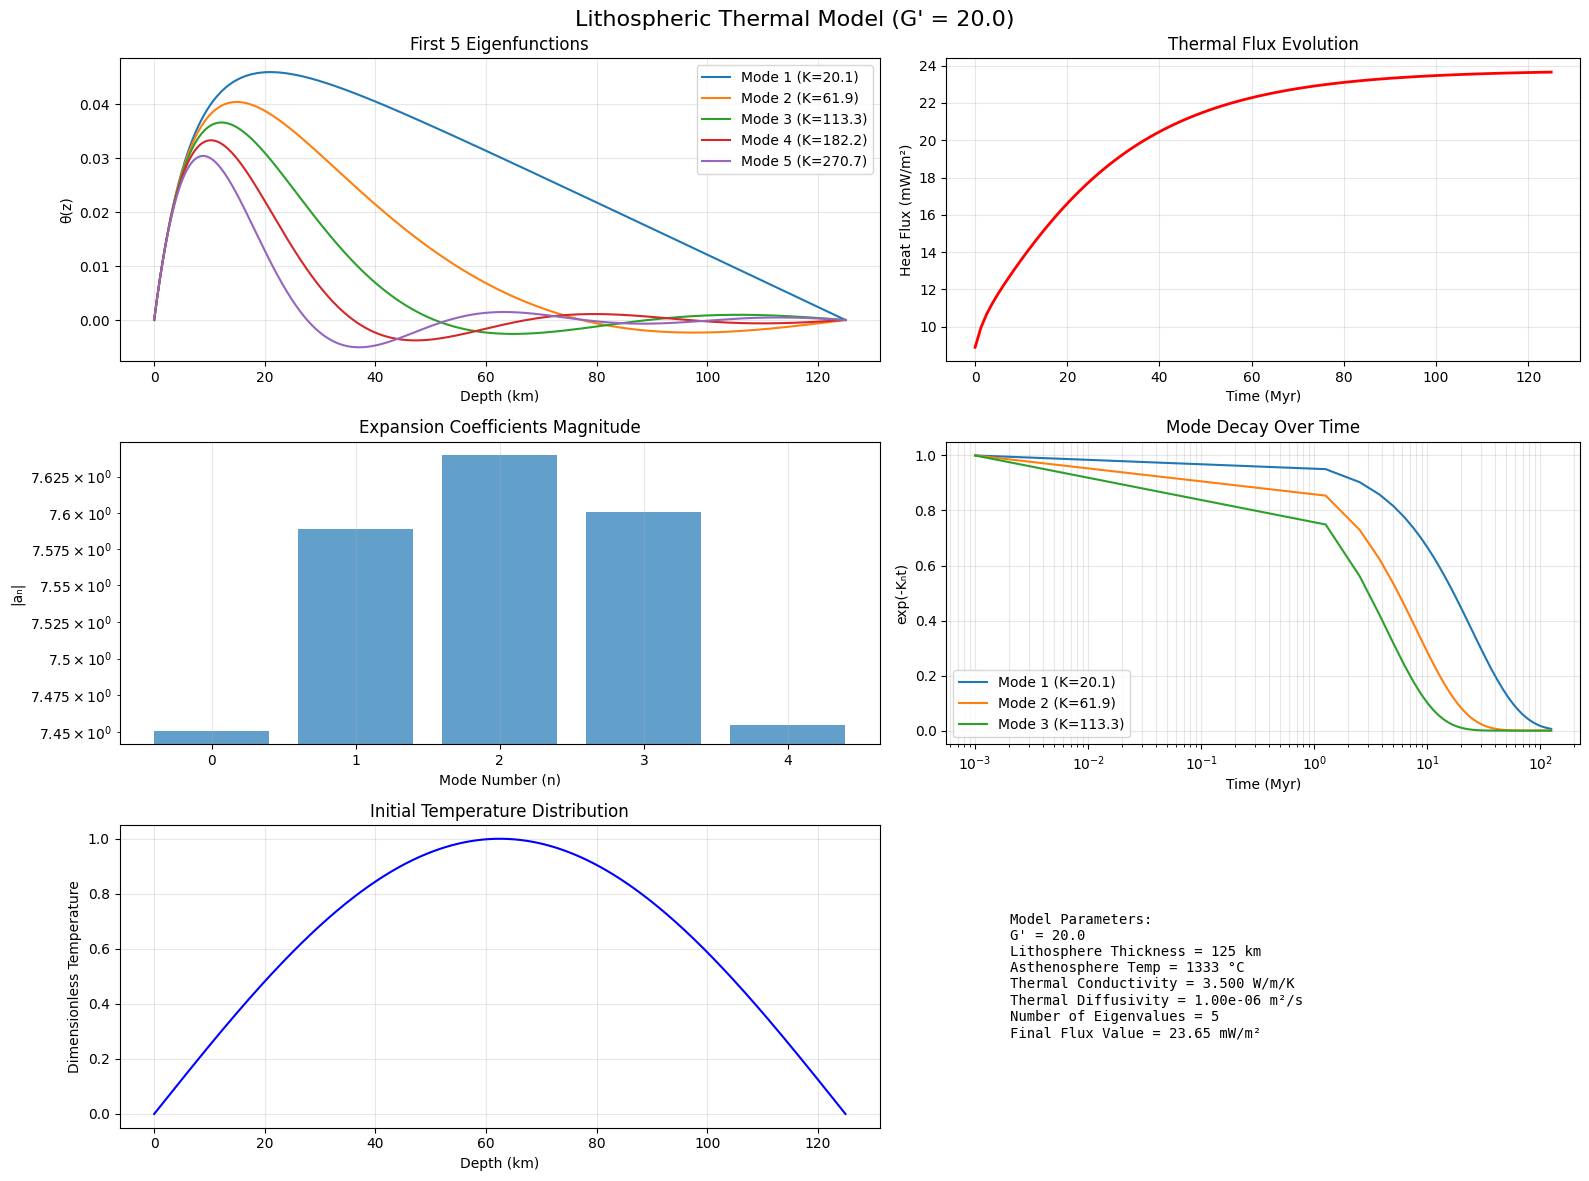

NameError: name 'eigenfilename' is not defined

In [ ]:
def main():
    G_prime = 20.0
    # time_range = np.logspace(-2, 2, 500)  # 0.01 to 100 Myr (logarithmic)
    time_range = np.linspace(1e-3, 125, 100)  # 0.01 to 100 Myr (logarithmic)

    print("Initializing thermal model...")
    model = EnhancedThermalModel(G_prime, n_eigenvalues=5)

    print("\nComputing model components...")
    model.find_eigenvalues()  # Changed from _find_eigenvalues()
    model.compute_eigenfunctions()  # Changed from _compute_eigenfunctions()
    model.compute_derivatives()  # Added this missing call
    model.compute_coefficients(initial_condition)

    print("\nCalculating thermal flux history...")
    flux_history = model.compute_flux_history(time_range)

    plot_results(model, time_range, flux_history)
    model.save_results(time_range, flux_history)

    print("\nAnalysis complete.")

if __name__ == "__main__":
    main()

In [ ]:
# Create and run the model
model = EnhancedThermalModel(G_prime=10)
model.find_eigenvalues()
model.compute_eigenfunctions()
model.compute_derivatives()
model.compute_coefficients(initial_condition)

# Time range (0-200 Myr in 1 Myr steps)
time_range = np.arange(0, 201, 30)
flux_values = model.compute_flux_history(time_range)


# Create a more robust printing function
def print_heat_flow_data(time_range, flux_values, n=20):
    print("Time (Myr)\tHeat Flow (mW/m²)")
    print("----------------------------------")

    # Print first n entries
    for t, q in zip(time_range[:n], flux_values[:n]):
        print(f"{float(t):.1f}\t\t{q:.6f}")  # Using 6 decimal places

    print("...\t\t...")

    # Print last n entries
    for t, q in zip(time_range[-n:], flux_values[-n:]):
        print(f"{float(t):.1f}\t\t{q:.6f}")

# Print the data
print_heat_flow_data(time_range, flux_values)



Finding 20 eigenvalues...


100%|██████████| 20/20 [00:01<00:00, 17.14it/s]


Computing eigenfunctions...


100%|██████████| 20/20 [00:00<00:00, 112.15it/s]


Computing derivatives...


100%|██████████| 20/20 [00:00<00:00, 157.88it/s]


Computing expansion coefficients...


  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-144-1505102452>:109: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0]
<ipython-input-144-1505102452>:115: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0] / norm
100%|██████████| 7/7 [00:00<00:00, 7057.72it/s]

Time (Myr)	Heat Flow (mW/m²)
----------------------------------
0.0		-1.271488
30.0		5.138556
60.0		13.528578
90.0		18.513984
120.0		21.089710
150.0		22.394150
180.0		23.052819
...		...
0.0		-1.271488
30.0		5.138556
60.0		13.528578
90.0		18.513984
120.0		21.089710
150.0		22.394150
180.0		23.052819


In [ ]:
import pandas as pd
df = pd.DataFrame({'Time (Myr)': time_range, 'Heat Flow (mW/m²)': flux_values})
df.to_csv('heat_flow_results.csv', index=False)

Finding 20 eigenvalues...


100%|██████████| 20/20 [00:01<00:00, 14.45it/s]


Computing eigenfunctions...


100%|██████████| 20/20 [00:00<00:00, 92.38it/s] 


Computing derivatives...


100%|██████████| 20/20 [00:00<00:00, 135.89it/s]


Computing expansion coefficients...


  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-137-3439423165>:107: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0]
<ipython-input-137-3439423165>:113: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0, 1, limit=200)[0] / norm
100%|██████████| 300/300 [00:00<00:00, 13866.69it/s]


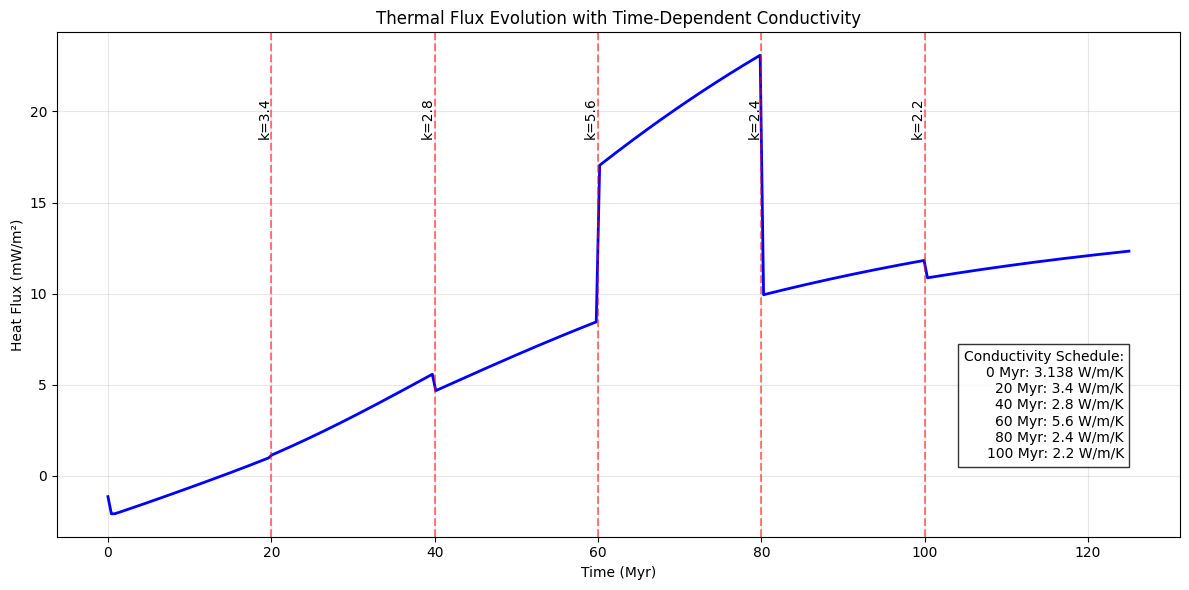

In [ ]:
class TimeDependentConductivityModel(EnhancedThermalModel):
    def __init__(self, G_prime, conductivity_schedule, n_eigenvalues=20, z_resolution=1000):
        """
        conductivity_schedule: dictionary of {time_myr: conductivity_value}
        """
        super().__init__(G_prime, n_eigenvalues, z_resolution)
        self.conductivity_schedule = conductivity_schedule
        self.sorted_times = sorted(conductivity_schedule.keys())

    def get_conductivity(self, t_myr):
        """Get conductivity for a given time"""
        # Find the largest time in schedule that is <= t_myr
        for time in reversed(self.sorted_times):
            if t_myr >= time:
                return self.conductivity_schedule[time]
        return self.conductivity_schedule[self.sorted_times[0]]

    def thermal_flux(self, t_myr):
        if None in [self.eigenvalues, self.coefficients, self.dtheta_n]:
            raise ValueError("Model not fully initialized")

        t_sec = t_myr * SECONDS_PER_MYR
        current_k = self.get_conductivity(t_myr)

        steady_term = (2/np.pi) * erf(np.sqrt(self.G_prime/2))

        transient_term = 0
        for an, Kn, dtheta in zip(self.coefficients, self.eigenvalues, self.dtheta_n):
            exponent = -Kn * kappa * t_sec / a**2
            transient_term += an * np.exp(exponent) * dtheta

        return (current_k * T1 / a) * (steady_term + transient_term) * 1000

def run_time_dependent_simulation():
    # Define conductivity schedule (time in Myr: conductivity in W/m/K)
    conductivity_schedule = {
        0: 3.138,    # Initial conductivity
        20: 3.4,     # Changed at 20 Myr
        40: 2.8,     # Changed at 40 Myr
        60: 5.6,     # Changed at 60 Myr
        80: 2.4,     # Changed at 80 Myr
        100: 2.2     # Changed at 100 Myr
    }

    # Create model
    model = TimeDependentConductivityModel(
        G_prime=10,
        conductivity_schedule=conductivity_schedule,
        n_eigenvalues=20
    )

    # Initialize model components
    model.find_eigenvalues()
    model.compute_eigenfunctions()
    model.compute_derivatives()
    model.compute_coefficients(initial_condition)

    # Time range for simulation
    time_range = np.linspace(0, 125, 300)  # 0-150 Myr

    # Compute flux history
    flux_values = model.compute_flux_history(time_range)

    # Plot results
    plt.figure(figsize=(12, 6))

    # Plot flux evolution
    plt.plot(time_range, flux_values, 'b-', linewidth=2)

    # Mark conductivity change points
    for t in conductivity_schedule:
        if t > 0:  # Don't mark t=0
            plt.axvline(x=t, color='r', linestyle='--', alpha=0.5)
            plt.text(t, np.max(flux_values)*0.9, f'k={conductivity_schedule[t]}',
                    rotation=90, va='top', ha='right')

    plt.title('Thermal Flux Evolution with Time-Dependent Conductivity')
    plt.xlabel('Time (Myr)')
    plt.ylabel('Heat Flux (mW/m²)')
    plt.grid(True, alpha=0.3)

    # Add conductivity schedule info
    plt.text(0.95, 0.15, "Conductivity Schedule:\n" +
             "\n".join([f"{t} Myr: {k} W/m/K"
                       for t, k in conductivity_schedule.items()]),
             transform=plt.gca().transAxes, ha='right', va='bottom',
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Run the simulation
run_time_dependent_simulation()

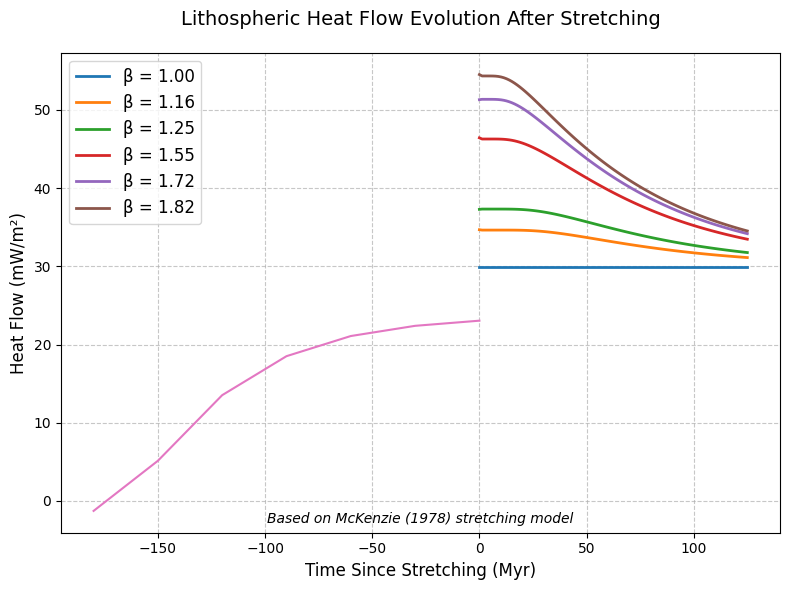

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union

def calculate_heat_flux(
    beta: Union[float, List[float]],
    time_myr: Union[float, np.ndarray],
    lithosphere_thickness_km: float = 125,
    thermal_time_constant_myr: float = 62.8,
    thermal_conductivity_wmk: float = 3.5,
    mantle_temperature_c: float = 1333,
    n_terms: int = 100
) -> np.ndarray:
    """
    Calculate heat flux for lithospheric stretching models using McKenzie's approach.

    Parameters:
        beta: Stretching factor(s) (float or list of floats)
        time_myr: Time since stretching event in million years (float or array)
        lithosphere_thickness_km: Thickness of lithosphere in km (default 125)
        thermal_time_constant_myr: Thermal time constant in Myr (default 62.8)
        thermal_conductivity_wmk: Thermal conductivity in W/m·K (default 3.5)
        mantle_temperature_c: Mantle temperature in °C (default 1333)
        n_terms: Number of terms in the series expansion (default 100)

    Returns:
        Array of heat flux values in mW/m²
    """

    beta_arr = np.atleast_1d(beta)
    time_arr = np.atleast_1d(time_myr)

    heat_flux = np.zeros((len(beta_arr), len(time_arr)))


    for i, b in enumerate(beta_arr):
        series_sum = 0.0
        for n in range(1, n_terms + 1):
            term = (b / (n * np.pi) * np.sin(n * np.pi / b) * np.exp(-n**2 * time_arr / thermal_time_constant_myr))
            series_sum += term

        # Calculate dimensionless temperature ratio
        T_over_Tm = 0.8 * (1 + 2 * series_sum)

        # Convert to heat flux (mW/m²)
        # heat_flux[i] = T_over_Tm * 60 * 697 *1e-3  # W/m² to mW/m², the factor 60*697*1e-3 from the original code
        heat_flux[i] = T_over_Tm * (thermal_conductivity_wmk * mantle_temperature_c /
                                   (lithosphere_thickness_km * 1000)) * 1e3  # W/m² to mW/m²

    return heat_flux.squeeze()  # Remove single-dimensional entries

# Parameters
beta_values = [1, 1.16, 1.25, 1.55, 1.72, 1.82]
time_values = np.linspace(0, 125, 100)

# Calculate heat flux
flux = calculate_heat_flux(beta_values, time_values)

# Plotting
plt.figure(figsize=(8, 6))
for i, b in enumerate(np.atleast_1d(beta_values)):
    plt.plot(time_values, flux[i] if len(np.atleast_1d(beta_values)) > 1 else flux,
             label=f'β = {b:.2f}',
             linewidth=2)


plt.plot(df['Time (Myr)'][::-1]*-1, df['Heat Flow (mW/m²)'])

plt.xlabel('Time Since Stretching (Myr)', fontsize=12)
plt.ylabel('Heat Flow (mW/m²)', fontsize=12)
plt.title('Lithospheric Heat Flow Evolution After Stretching', fontsize=14, pad=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.annotate('Based on McKenzie (1978) stretching model',
             xy=(0.5, 0.02), xycoords='axes fraction',
             ha='center', fontsize=10, style='italic')
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['Time (Myr)', 'Heat Flow (mW/m²)'], dtype='object')